# 1. Data preparation

In [3]:
import sklearn 
import pandas as pd  
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Read dataframes from datas folder

In [8]:
# Dictionary to store all teh dataframes
dataframes_dictionary = {}
# Counter just for verification
csvcount = 0

# Path to access to the .csv files (It might need to be modified when working on local environment)
directory = 'C:/Users/andre/Documents/MSc RENE/UPC/Data Science/Project/datascience/datas'

# Loop for reading all the dfs at once and storing them in a dictionary to easy handle it for common changes
    
for filename in os.listdir(directory):
    if filename.endswith(".csv"):  # Reads only the .csv files
        # Getting the file path
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Use the file name without '.csv' as df name
        var_name = filename[:-4]
        # Storing each dataframe into a dictionary
        dataframes_dictionary[var_name] = df
        
        #globals()[var_name] = df
        csvcount += 1
print(f"Number of files imported {csvcount}\n")

Number of files imported 6



Change to datetime and also remove the timezone, keeping the local timezone, not the UTC one

In [9]:
#Change to datetime
for keys in dataframes_dictionary:
    dataframes_dictionary[keys]['datetime'] = pd.to_datetime(dataframes_dictionary[keys]['datetime'])

#Remove timezone info
for keys in dataframes_dictionary:
    dataframes_dictionary[keys]['datetime'] = dataframes_dictionary[keys]['datetime'].apply(lambda x: x.replace(tzinfo=None))

Check for duplicates, they generally appear on October, when summer time shifts to winter time.

In [10]:
for keys in dataframes_dictionary:
    duplicates = dataframes_dictionary[keys][dataframes_dictionary[keys].duplicated(subset='datetime',keep=False)] 
    print(duplicates)

                 datetime          datetime_utc  geo_id   geo_name  \
7153  2014-10-26 02:00:00  2014-10-26T00:00:00Z    8741  Península   
7154  2014-10-26 02:00:00  2014-10-26T01:00:00Z    8741  Península   
15889 2015-10-25 02:00:00  2015-10-25T00:00:00Z    8741  Península   
15890 2015-10-25 02:00:00  2015-10-25T01:00:00Z    8741  Península   
24793 2016-10-30 02:00:00  2016-10-30T00:00:00Z    8741  Península   
24794 2016-10-30 02:00:00  2016-10-30T01:00:00Z    8741  Península   
33529 2017-10-29 02:00:00  2017-10-29T00:00:00Z    8741  Península   
33530 2017-10-29 02:00:00  2017-10-29T01:00:00Z    8741  Península   
42265 2018-10-28 02:00:00  2018-10-28T00:00:00Z    8741  Península   
42266 2018-10-28 02:00:00  2018-10-28T01:00:00Z    8741  Península   
51001 2019-10-27 02:00:00  2019-10-27T00:00:00Z    8741  Península   
51002 2019-10-27 02:00:00  2019-10-27T01:00:00Z    8741  Península   
59737 2020-10-25 02:00:00  2020-10-25T00:00:00Z    8741  Península   
59738 2020-10-25 02:

In [11]:
#Remove duplicates, keep last value
for keys in dataframes_dictionary:
    dataframes_dictionary[keys] = dataframes_dictionary[keys].drop_duplicates(subset='datetime',keep='last')

In [12]:
#Set datetime as index
for keys in dataframes_dictionary:
    dataframes_dictionary[keys] = dataframes_dictionary[keys].set_index('datetime')

In [13]:
# Give a commun date_range
date_range = pd.date_range(start=dataframes_dictionary["price_DA"].index.min(), end=dataframes_dictionary["price_DA"].index.max(), freq='H')
print(date_range)

for keys in dataframes_dictionary:
    dataframes_dictionary[keys] = dataframes_dictionary[keys].reindex(date_range)

DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 01:00:00',
               '2014-01-01 02:00:00', '2014-01-01 03:00:00',
               '2014-01-01 04:00:00', '2014-01-01 05:00:00',
               '2014-01-01 06:00:00', '2014-01-01 07:00:00',
               '2014-01-01 08:00:00', '2014-01-01 09:00:00',
               ...
               '2024-10-31 14:00:00', '2024-10-31 15:00:00',
               '2024-10-31 16:00:00', '2024-10-31 17:00:00',
               '2024-10-31 18:00:00', '2024-10-31 19:00:00',
               '2024-10-31 20:00:00', '2024-10-31 21:00:00',
               '2024-10-31 22:00:00', '2024-10-31 23:00:00'],
              dtype='datetime64[ns]', length=94968, freq='H')


Some graphs of daily hourly profiles just to see if the data makes sense...

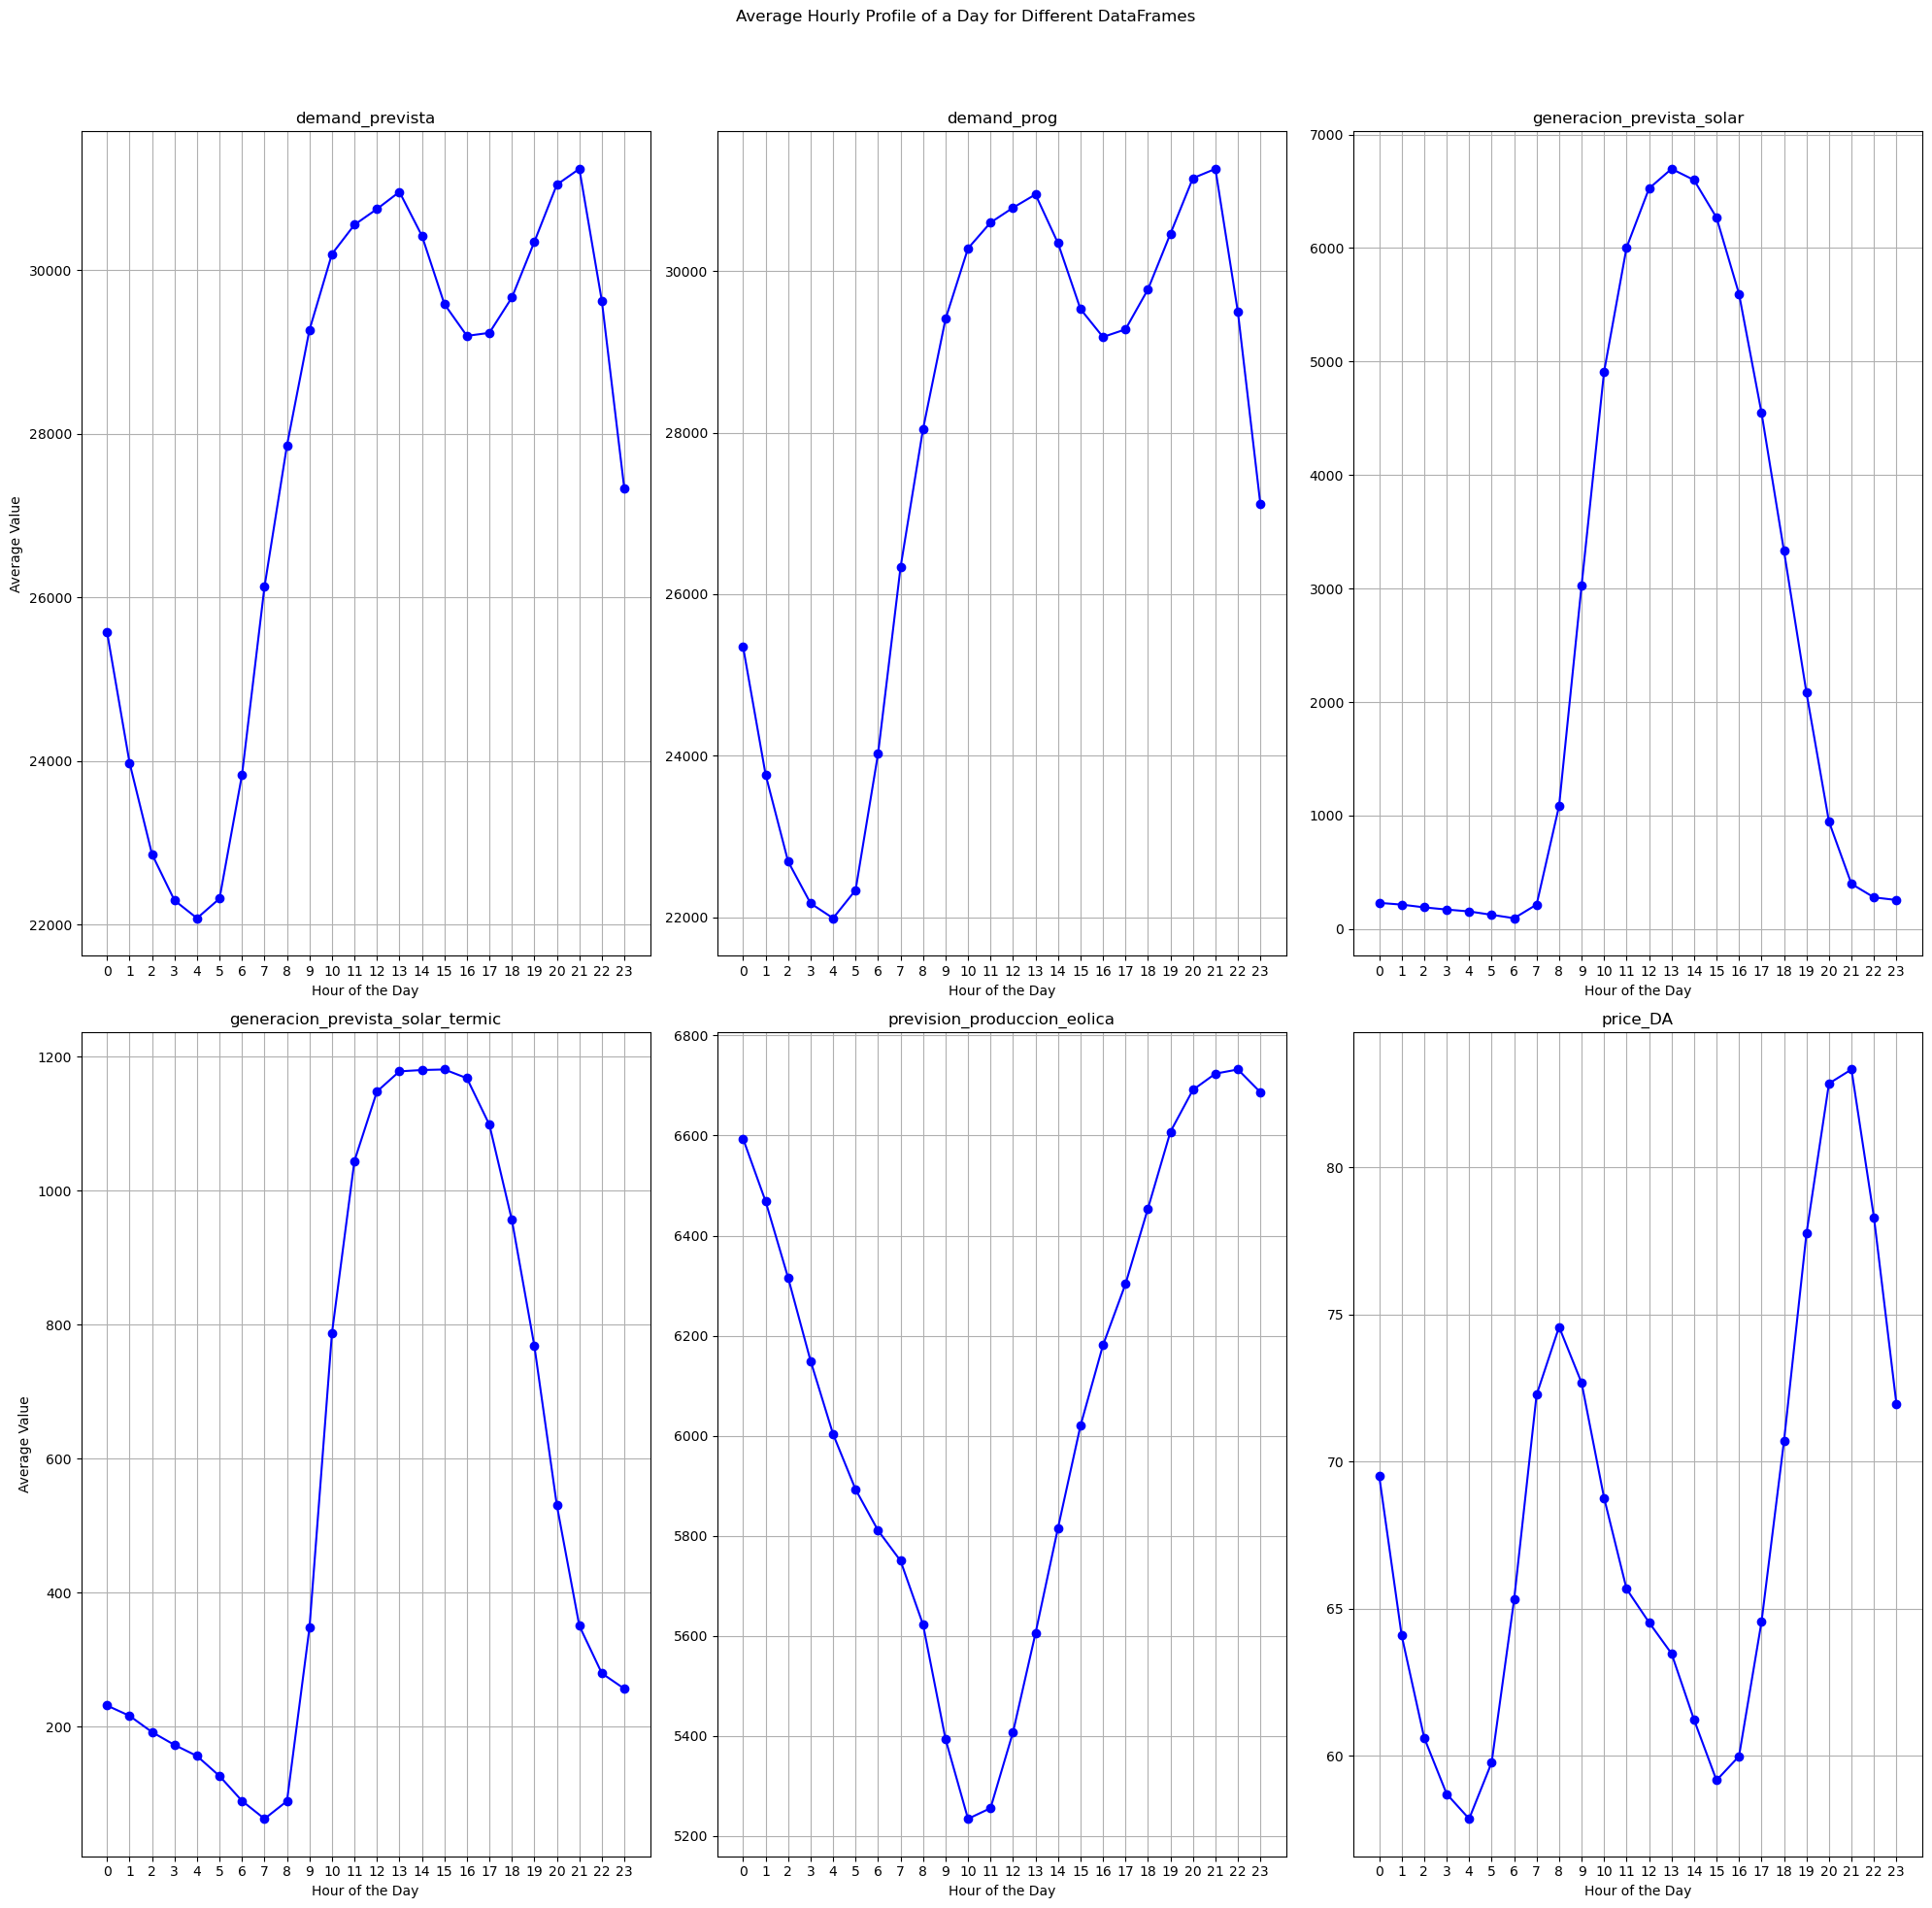

In [14]:
import matplotlib.pyplot as plt

# Set up a 3xlen(dataframes_dictionnary) subplot grid
fig, axs = plt.subplots(2, len(dataframes_dictionary)//3+1, figsize=(20, 20))
fig.suptitle("Average Hourly Profile of a Day for Different DataFrames")

# Loop over each DataFrame, calculate the average hourly profile, and plot
col = 0
row = 0
for keys in dataframes_dictionary:
    # Group by hour of the day and calculate the mean for each hour
    average_hourly_profile = dataframes_dictionary[keys].groupby(dataframes_dictionary[keys].index.hour)['value'].mean()
    
    # Plot on the corresponding subplot
    axs[row, col].plot(average_hourly_profile, marker='o', color='b')
    axs[row, col].set_title(keys)
    axs[row, col].set_xlabel("Hour of the Day")
    axs[row, col].set_xticks(range(0, 24))
    axs[row, col].grid(True)
    col += 1
    if col > 2:
        col = 0
        row += 1

# Set a common y-label for all subplots
for ax in axs[:, 0]:  # Pour chaque ligne de la première colonne
    ax.set_ylabel("Average Value")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()

In [15]:
# Rename the 'value' columns in each DataFrame to reflect their data source
for keys in dataframes_dictionary:
    dataframes_dictionary[keys] = dataframes_dictionary[keys].rename(columns={'value': f'{keys}'})

# Concatenate the DataFrames, aligning on the index of prices_DA_full
dataframes_to_concat = [dataframes_dictionary['price_DA']['price_DA']]  # Start with the prices DataFrame

# Add the renamed DataFrames from the dataframes_dictionnary to the list
for keys in dataframes_dictionary:
    if keys != 'price_DA':
        dataframes_to_concat.extend([dataframes_dictionary[keys][keys]])

full_data = pd.concat(dataframes_to_concat, axis=1)

# Display the concatenated DataFrame
full_data

price_DA  demand_prevista  demand_prog  \
2014-01-01 00:00:00     20.02     23878.333333      24099.0   
2014-01-01 01:00:00     10.34     23322.000000      22269.0   
2014-01-01 02:00:00      5.35     21711.166667      21136.0   
2014-01-01 03:00:00      5.00     20230.333333      19911.0   
2014-01-01 04:00:00      0.50     19215.333333      19060.0   
...                       ...              ...          ...   
2024-10-31 19:00:00    135.01     30143.666667      29705.5   
2024-10-31 20:00:00    148.72     29875.750000      29545.5   
2024-10-31 21:00:00    134.34     29014.000000      28285.5   
2024-10-31 22:00:00    115.20     26512.166667      25917.0   
2024-10-31 23:00:00    102.00     25230.000000      24393.0   

                     generacion_prevista_solar  \
2014-01-01 00:00:00                       3.50   
2014-01-01 01:00:00                       0.00   
2014-01-01 02:00:00                       0.00   
2014-01-01 03:00:00                       0.50   
2014-01-01 04:00:00                       2.20   
...                                        ...   
2024-10-31 19:00:00                      82.55   
2024-10-31 20:00:00                      94.40   
2024-10-31 21:00:00                      97.75   
2024-10-31 22:00:00                      64.15   
2024-10-31 23:00:00                      67.50   

                     generacion_prevista_solar_termic  \
2014-01-01 00:00:00                              3.50   
2014-01-01 01:00:00                              0.00   
2014-01-01 02:00:00                              0.00   
2014-01-01 03:00:00                              0.50   
2014-01-01 04:00:00                              2.20   
...                                               ...   
2024-10-31 19:00:00                             82.55   
2024-10-31 20:00:00                             94.40   
2024-10-31 21:00:00                             97.75   
2024-10-31 22:00:00                             64.15   
2024-10-31 23:00:00                             67.50   

                     prevision_produccion_eolica  
2014-01-01 00:00:00                     10790.00  
2014-01-01 01:00:00                     10885.00  
2014-01-01 02:00:00                     10984.00  
2014-01-01 03:00:00                     10680.00  
2014-01-01 04:00:00                     10605.00  
...                                          ...  
2024-10-31 19:00:00                      3972.75  
2024-10-31 20:00:00                      4615.25  
2024-10-31 21:00:00                      4913.00  
2024-10-31 22:00:00                      4820.25  
2024-10-31 23:00:00                      4765.00  

[94968 rows x 6 columns]

Some column renaming

In [16]:
full_data.rename(columns = {'demand_prevista':'demand_fore',
                            'demand_prog':'demand_scheduled',
                            'generacion_prevista_solar':'solar_gen_fore',
                            'generacion_prevista_solar_termic':'solar_thermal_fore',
                            'prevision_produccion_eolica':'wind_gen_fore'}, inplace = True)
full_data


price_DA   demand_fore  demand_scheduled  solar_gen_fore  \
2014-01-01 00:00:00     20.02  23878.333333           24099.0            3.50   
2014-01-01 01:00:00     10.34  23322.000000           22269.0            0.00   
2014-01-01 02:00:00      5.35  21711.166667           21136.0            0.00   
2014-01-01 03:00:00      5.00  20230.333333           19911.0            0.50   
2014-01-01 04:00:00      0.50  19215.333333           19060.0            2.20   
...                       ...           ...               ...             ...   
2024-10-31 19:00:00    135.01  30143.666667           29705.5           82.55   
2024-10-31 20:00:00    148.72  29875.750000           29545.5           94.40   
2024-10-31 21:00:00    134.34  29014.000000           28285.5           97.75   
2024-10-31 22:00:00    115.20  26512.166667           25917.0           64.15   
2024-10-31 23:00:00    102.00  25230.000000           24393.0           67.50   

                     solar_thermal_fore  wind_gen_fore  
2014-01-01 00:00:00                3.50       10790.00  
2014-01-01 01:00:00                0.00       10885.00  
2014-01-01 02:00:00                0.00       10984.00  
2014-01-01 03:00:00                0.50       10680.00  
2014-01-01 04:00:00                2.20       10605.00  
...                                 ...            ...  
2024-10-31 19:00:00               82.55        3972.75  
2024-10-31 20:00:00               94.40        4615.25  
2024-10-31 21:00:00               97.75        4913.00  
2024-10-31 22:00:00               64.15        4820.25  
2024-10-31 23:00:00               67.50        4765.00  

[94968 rows x 6 columns]

Check NaNs and drop them, sometimes Nans also occur when shifting from winter time to summer time.

In [17]:
#Check NaNs
full_data.isna().sum()

price_DA              11
demand_fore           11
demand_scheduled      11
solar_gen_fore        32
solar_thermal_fore    32
wind_gen_fore         31
dtype: int64

Number of NaNs is not relevant, we'll drop them. 

In [18]:
#Drop them
full_data.dropna(inplace=True,subset=['solar_gen_fore',
                                      'wind_gen_fore',
                                      'solar_thermal_fore',
                                      'demand_fore',
                                      'demand_scheduled'])
full_data.isna().sum()

price_DA              0
demand_fore           0
demand_scheduled      0
solar_gen_fore        0
solar_thermal_fore    0
wind_gen_fore         0
dtype: int64

# END OF DATA PREPARATION
___

# 2. Data Exploration

In [19]:
# Stats
total_stats = full_data.agg(['mean', 'var'])
# Group by year and calculate mean, median, and variance for each numeric column
yearly_stats = full_data.groupby(full_data.index.year).agg(['mean', 'var'])
# Group by month and calculate statistics
monthly_stats = full_data.groupby(full_data.index.month).agg(['mean', 'var'])

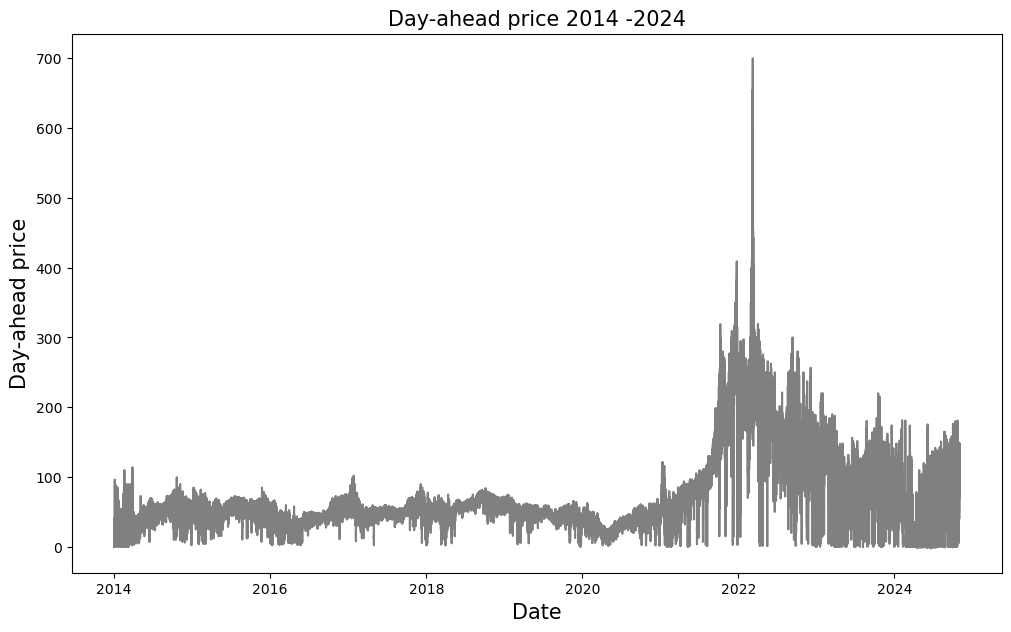

In [20]:
# Plotting the Day Ahead Price to identify trends.
plt.figure(figsize=(12,7))
plt.plot(full_data['price_DA'], color='grey')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Day-ahead price', fontsize=15)
plt.title('Day-ahead price 2014 -2024', fontsize=15)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


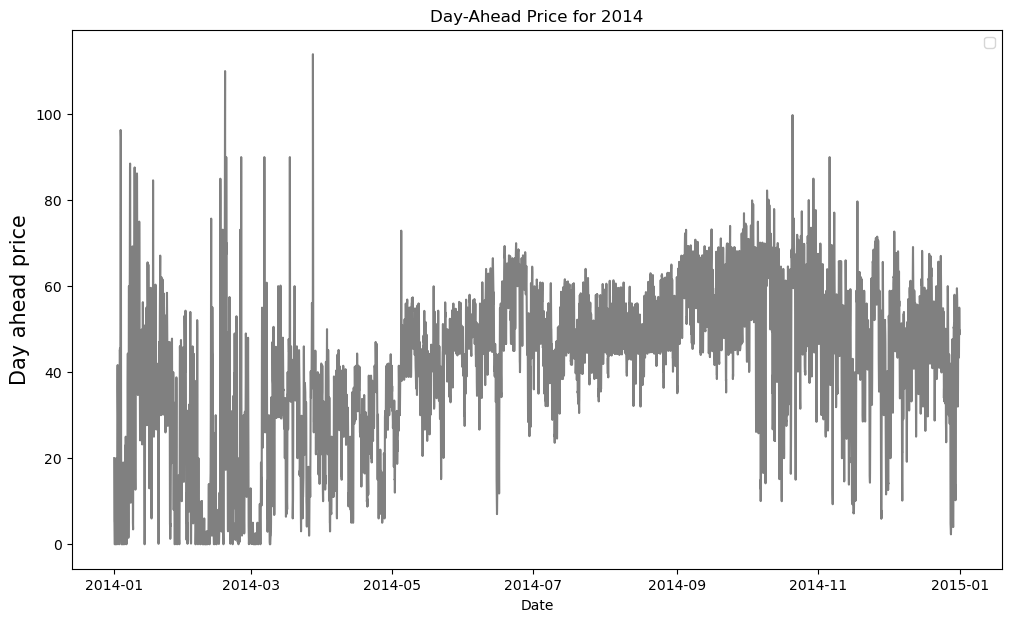

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


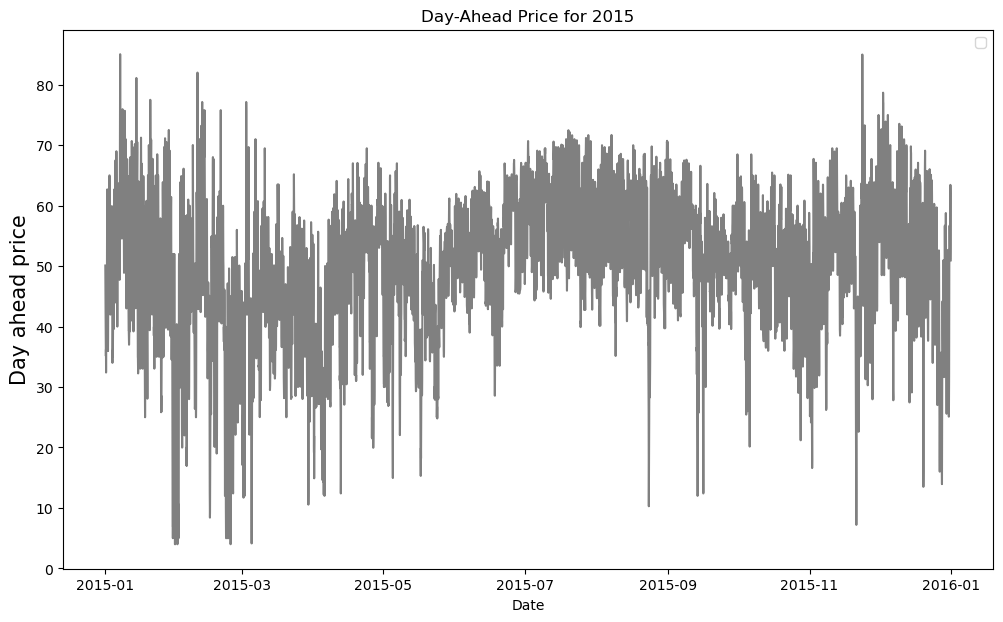

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


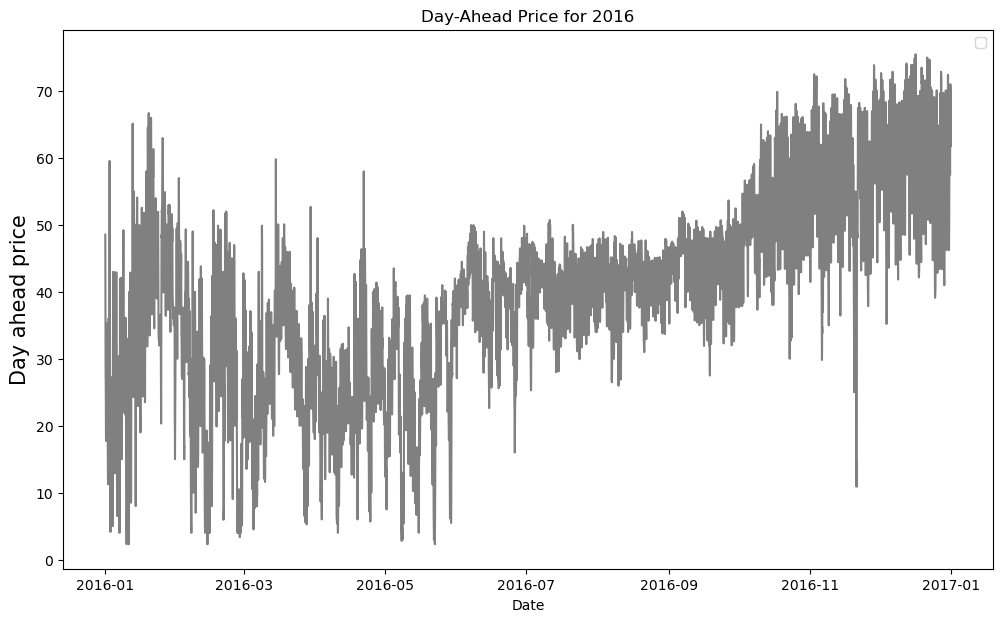

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


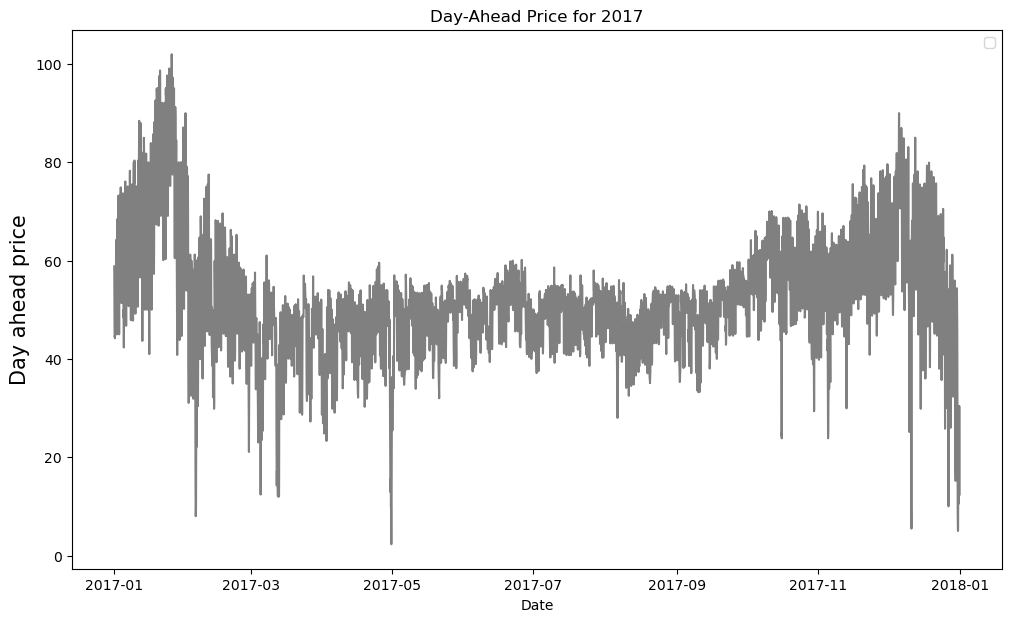

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


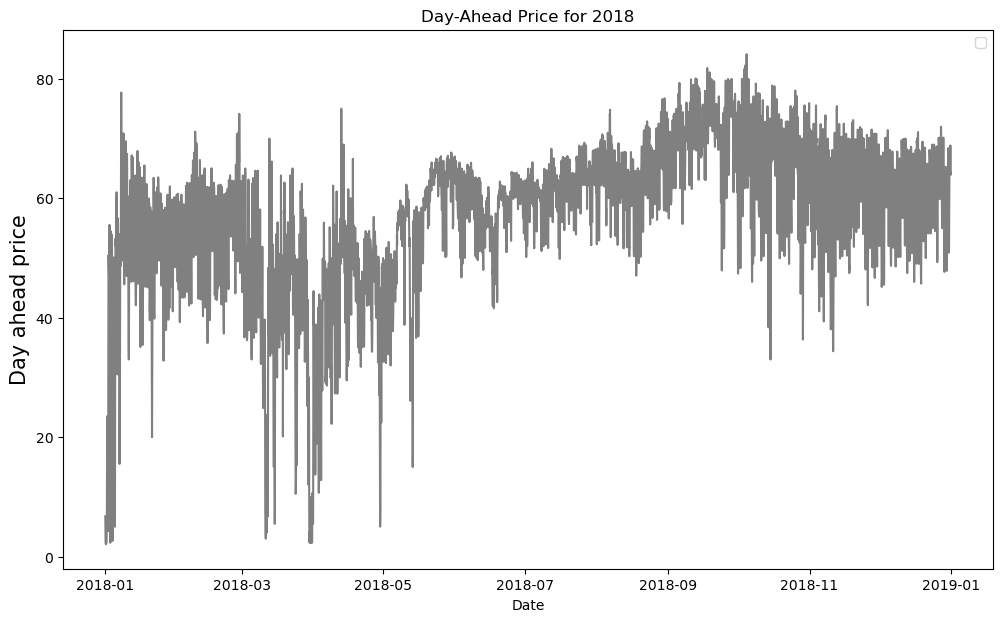

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


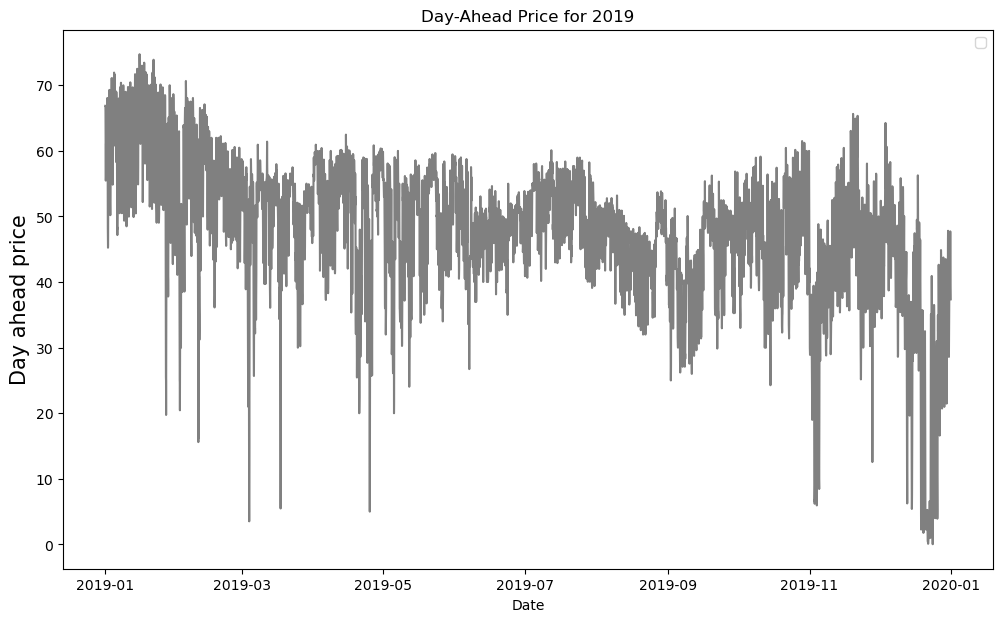

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


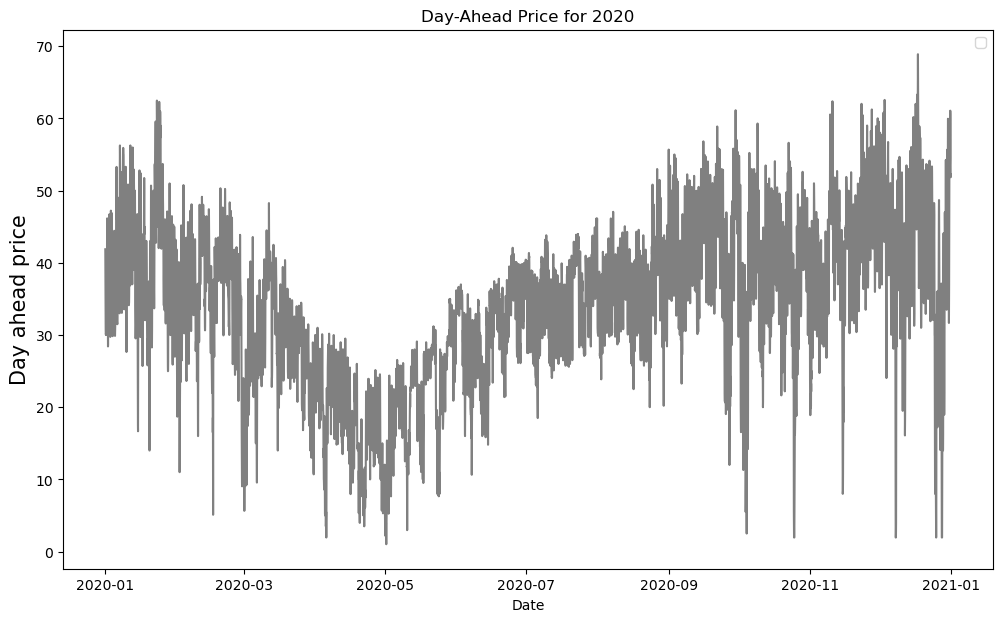

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


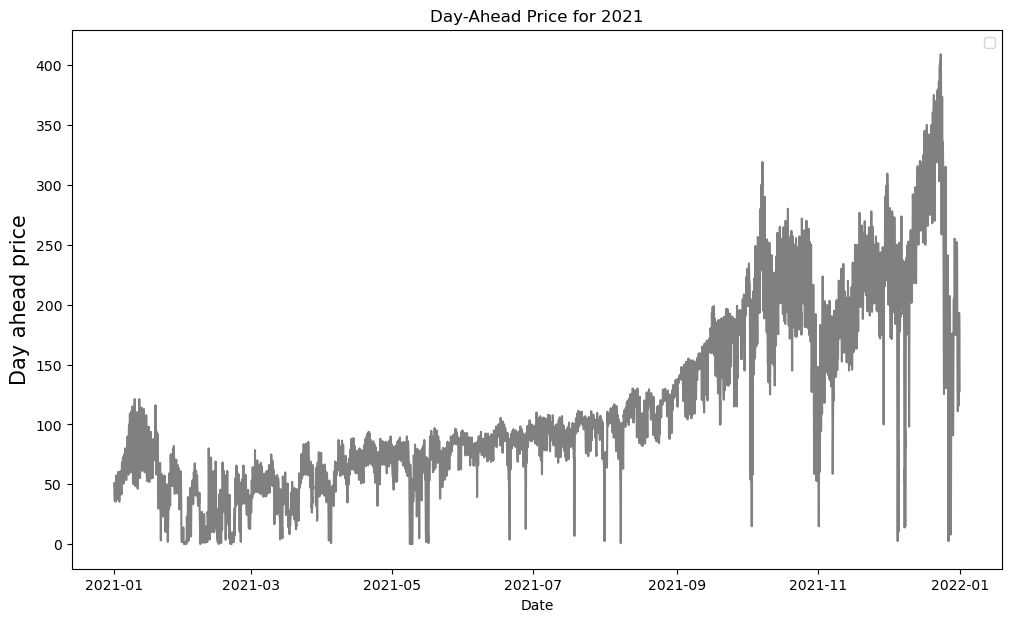

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


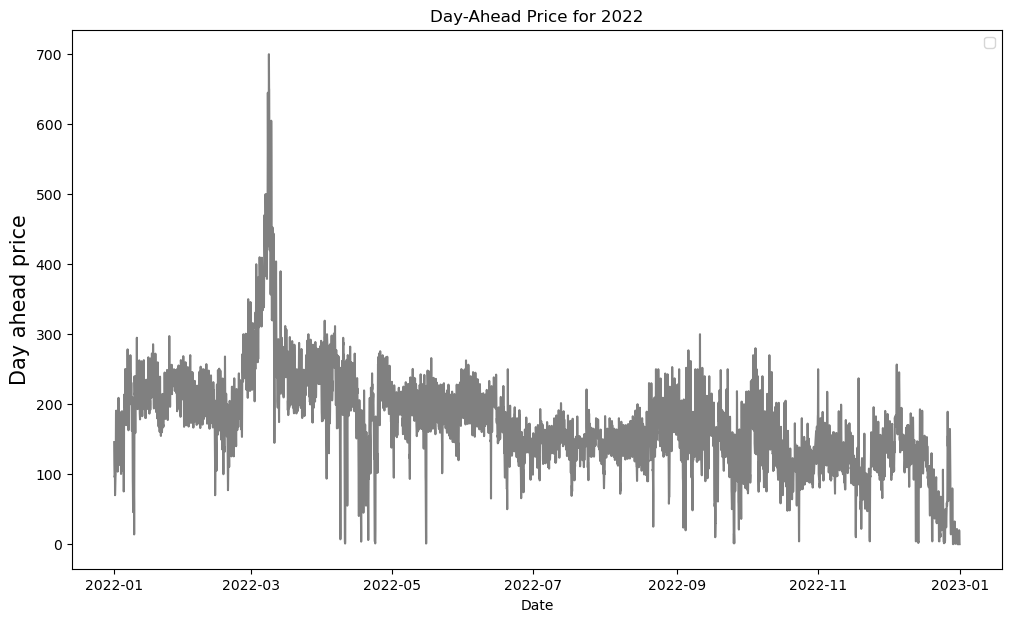

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


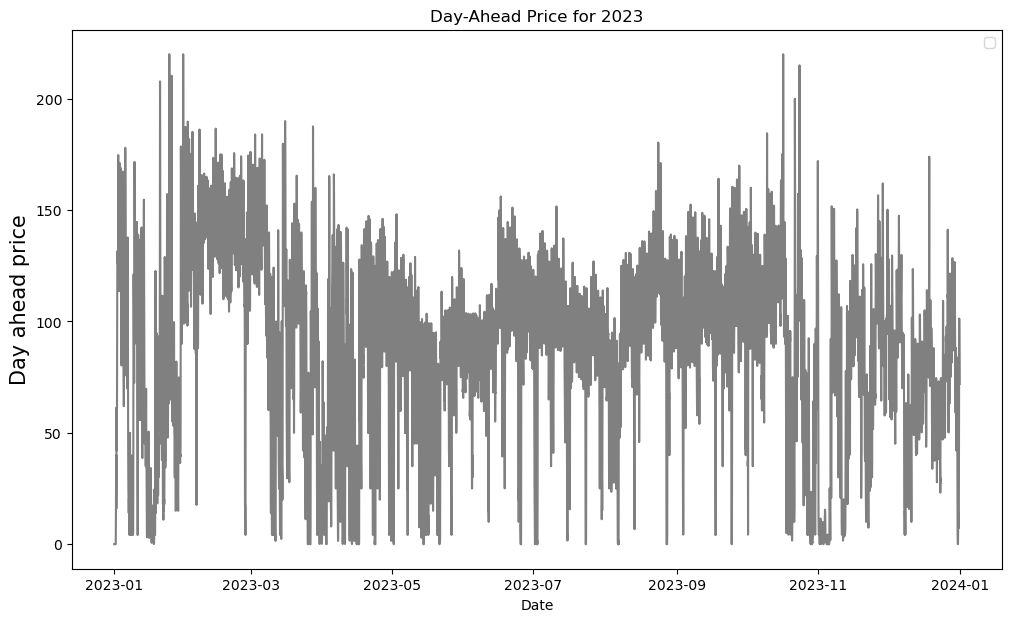

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


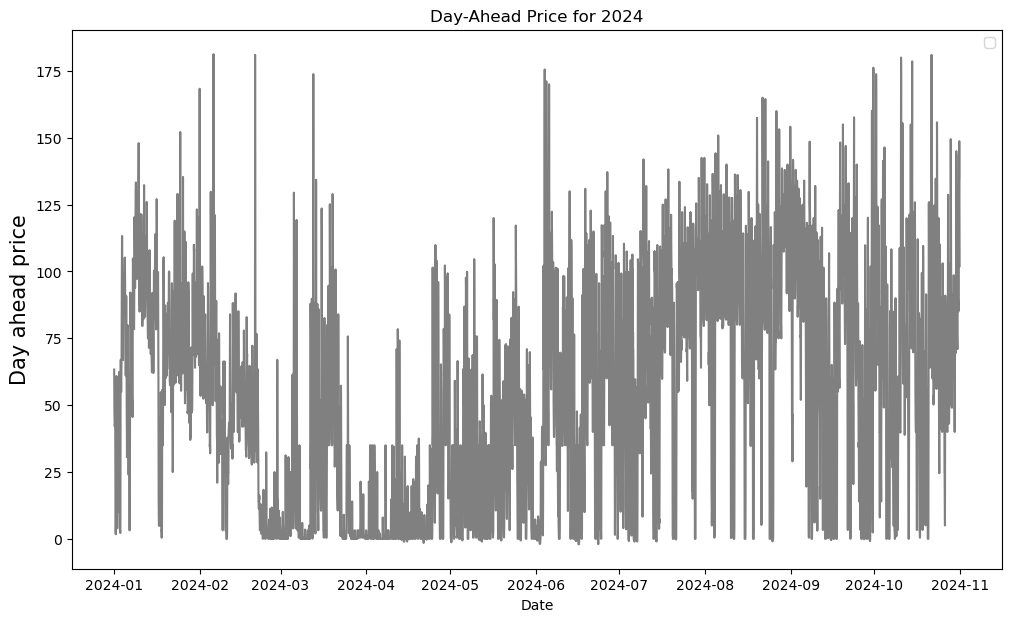

In [21]:
# Day ahead price per year.
for year, data in full_data.groupby(full_data.index.year):
    
    plt.figure(figsize=(12, 7))
    plt.plot(data['price_DA'], color = 'grey')
    plt.title(f'Day-Ahead Price for {year}')
    plt.xlabel('Date')
    plt.ylabel('Day ahead price', fontsize=15)
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


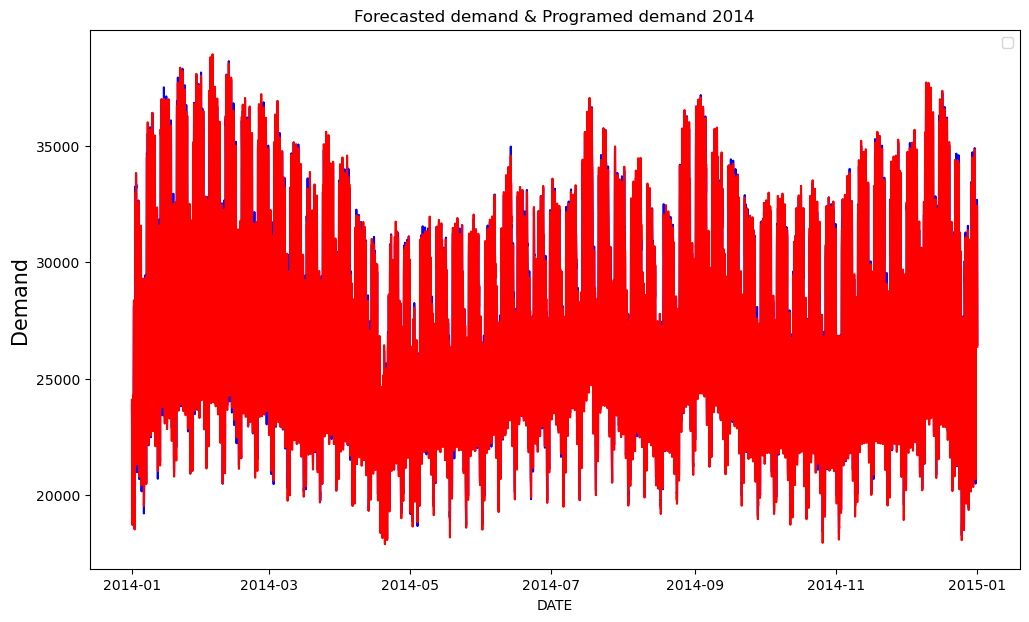

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


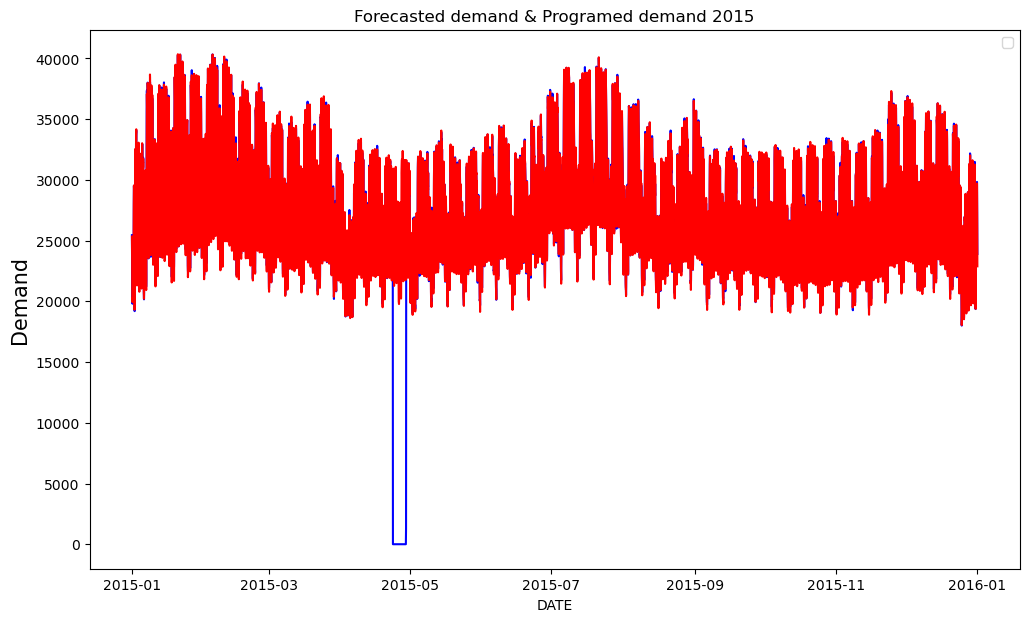

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


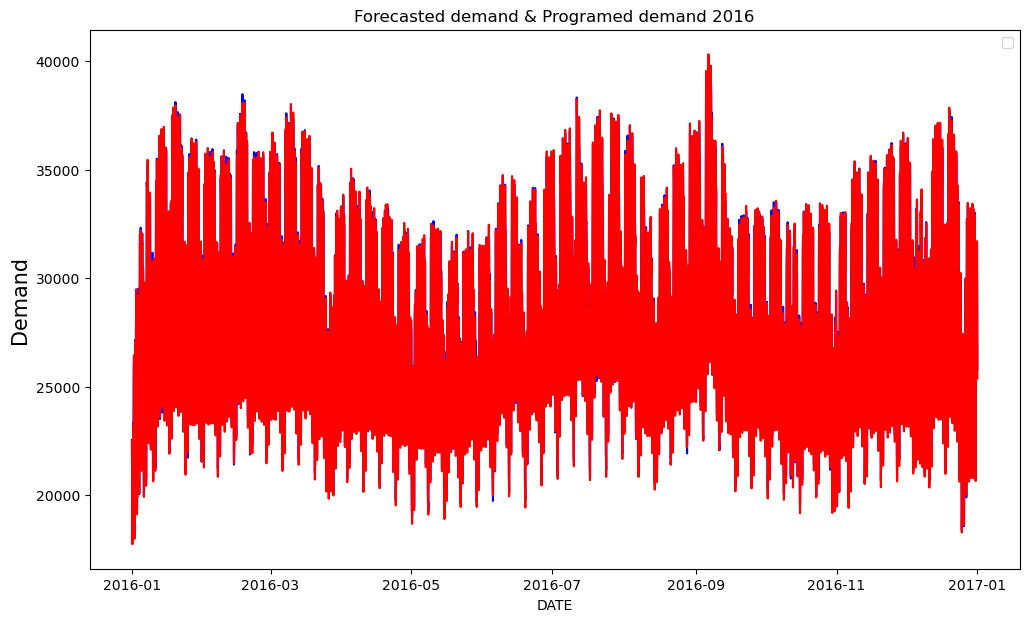

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


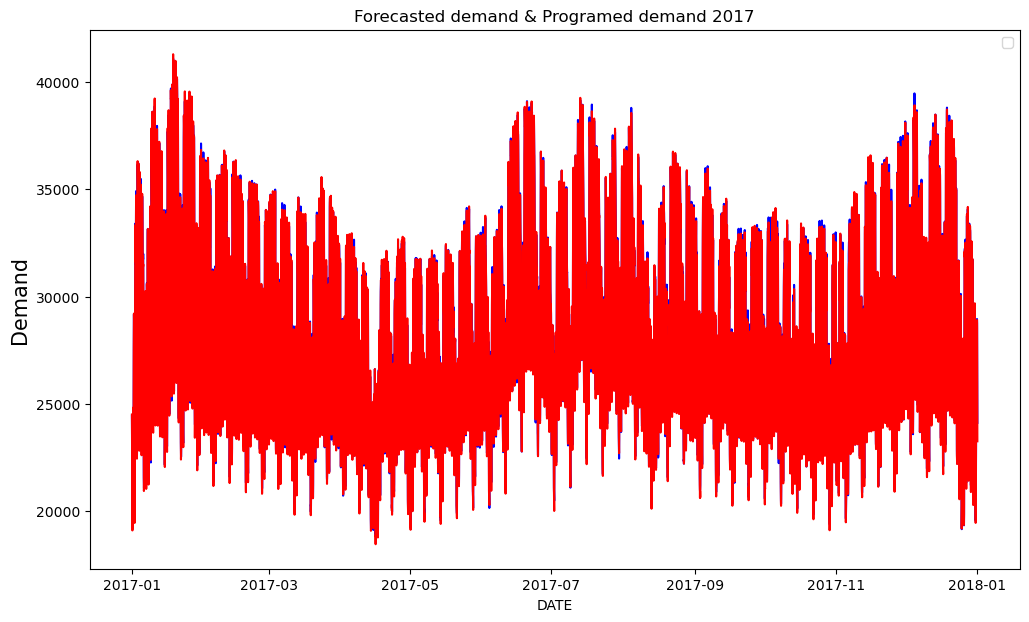

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


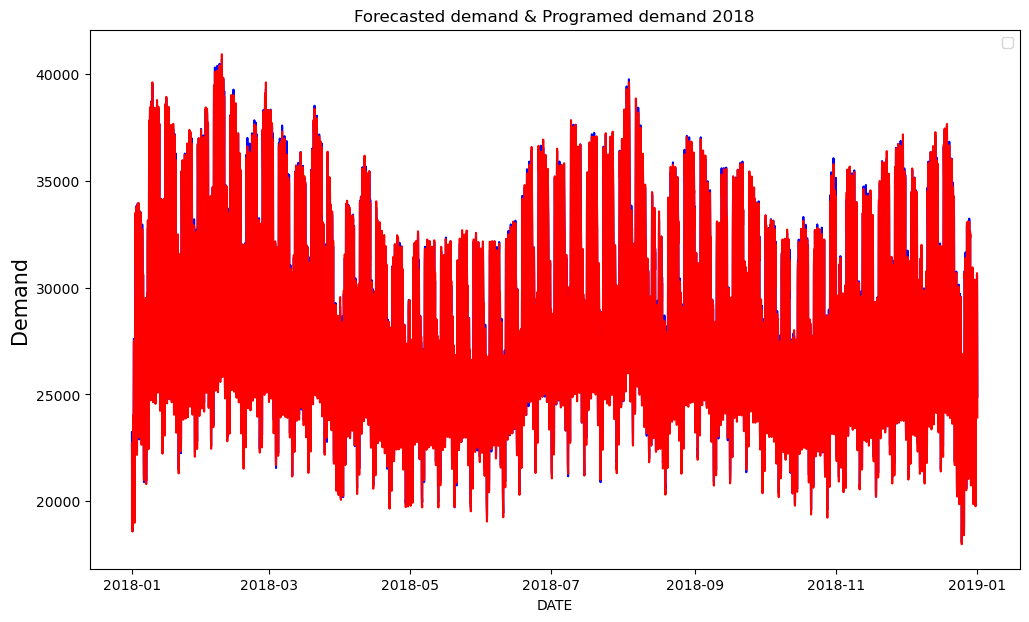

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


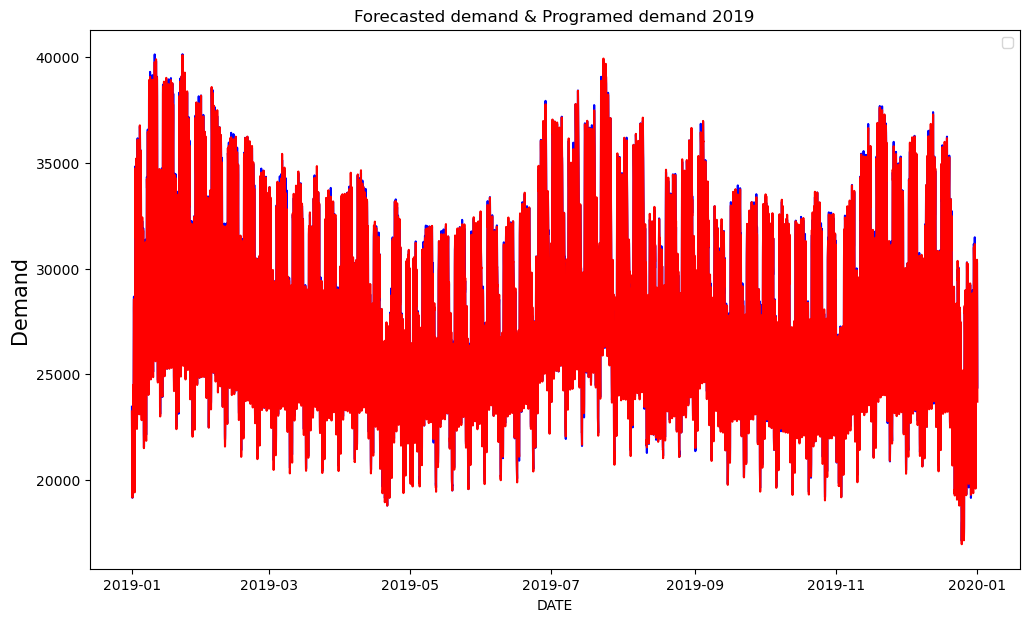

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


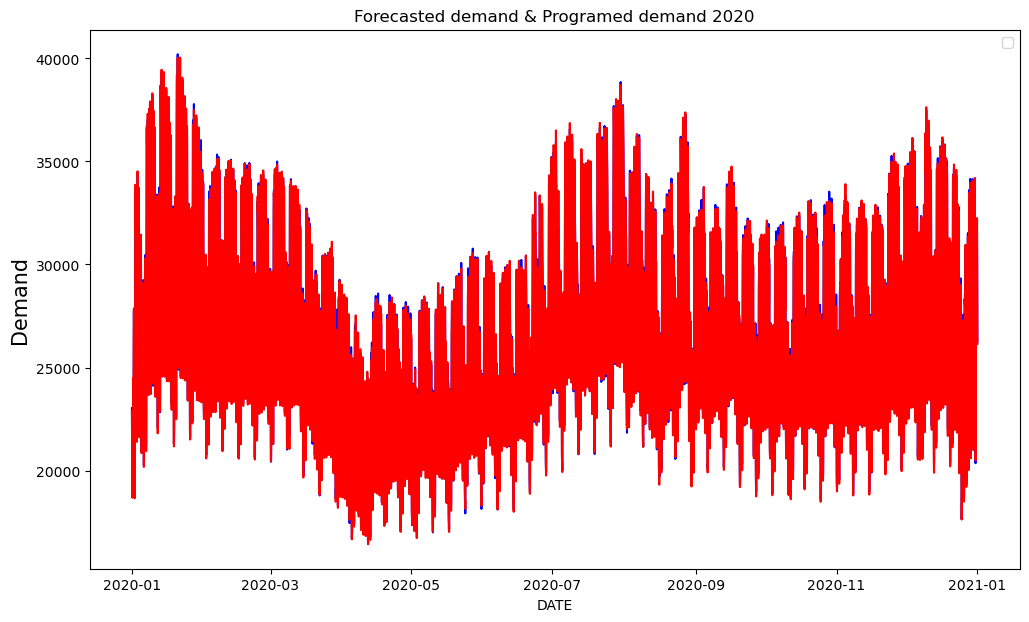

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


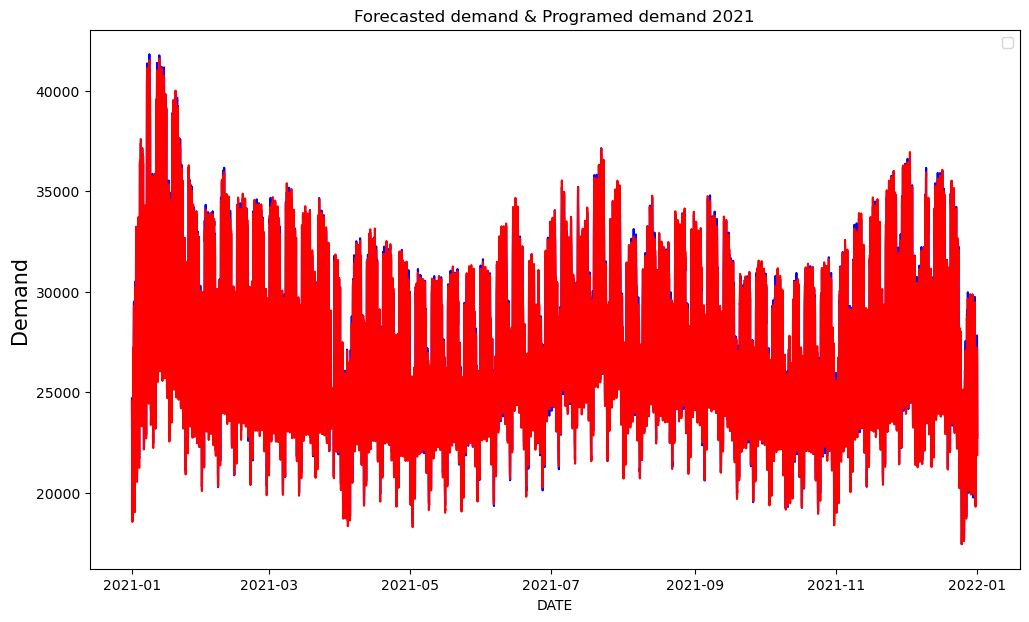

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


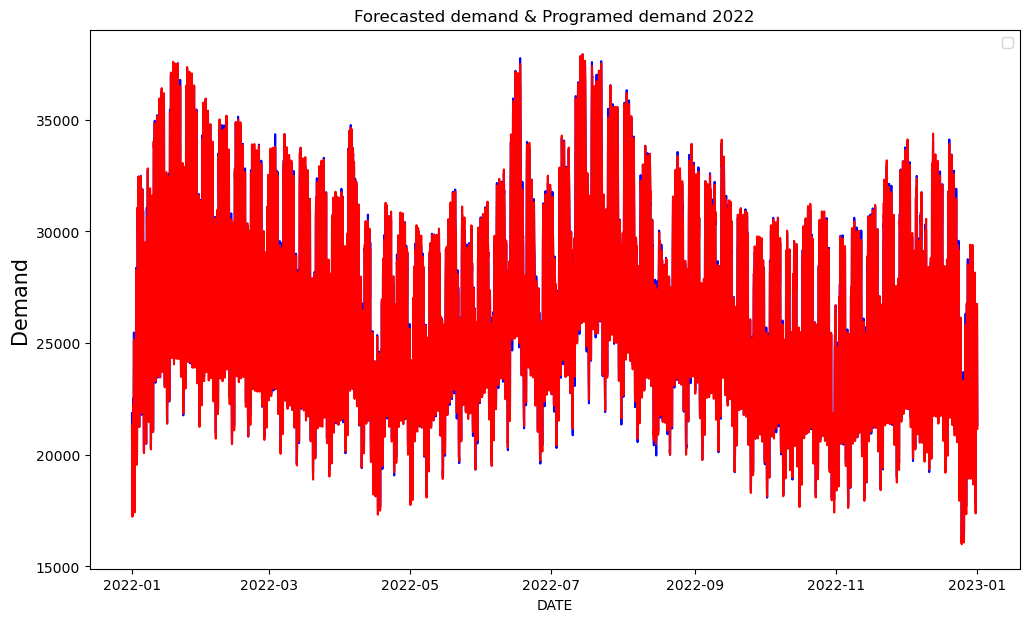

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


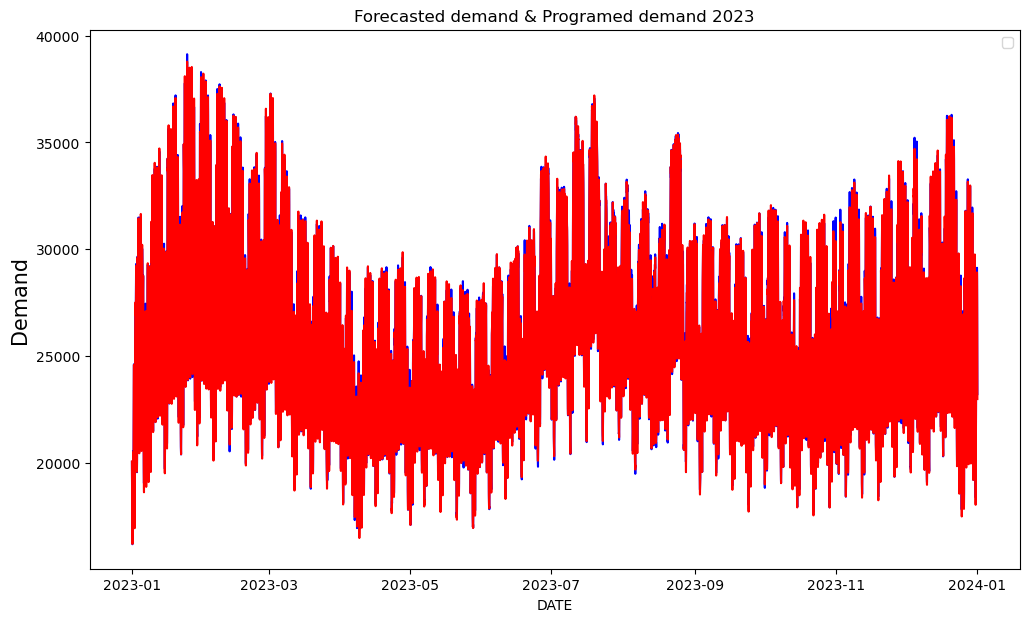

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


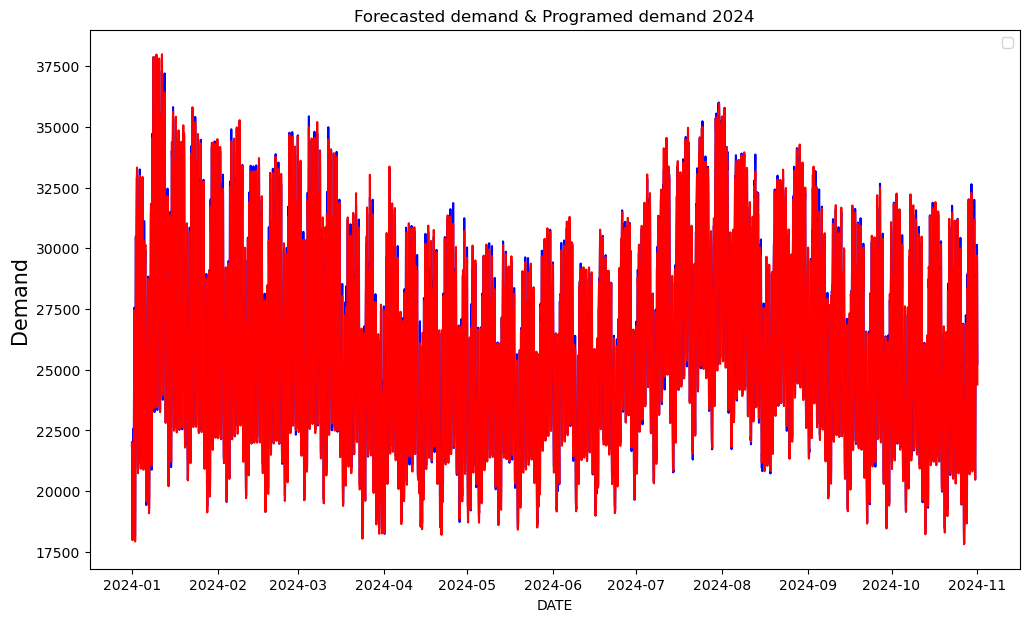

In [22]:
# Forecasted demand & Programed demand per year
for year, data in full_data.groupby(full_data.index.year):
    
    plt.figure(figsize=(12, 7))
    plt.plot(data['demand_fore'], color = 'blue')
    plt.plot(data['demand_scheduled'], color = 'red')
    plt.title(f'Forecasted demand & Programed demand {year}')
    plt.xlabel('DATE')
    plt.ylabel('Demand', fontsize=15)
    plt.legend()
    plt.show()

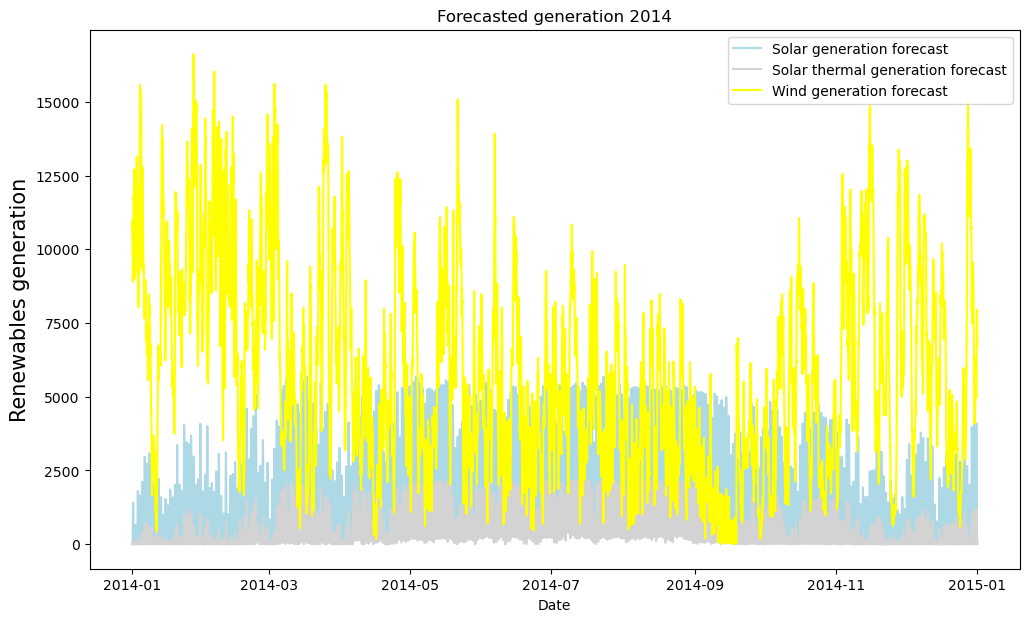

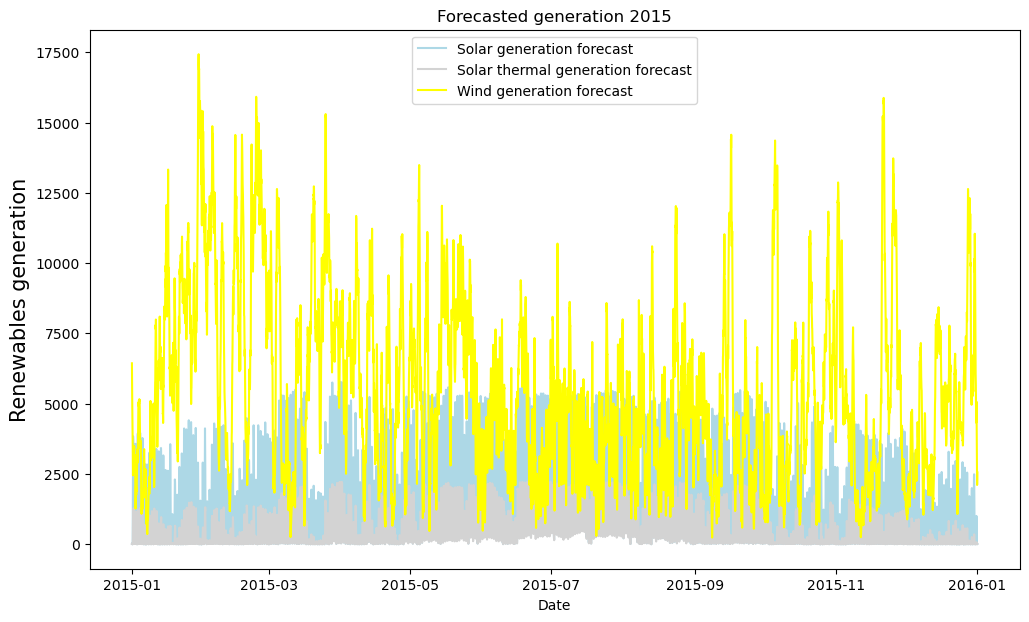

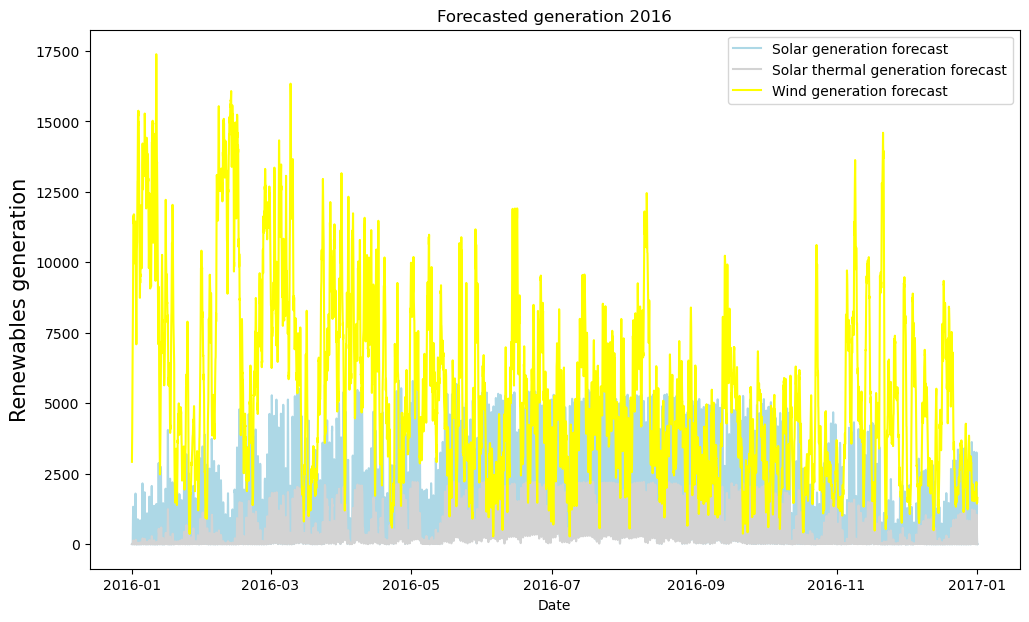

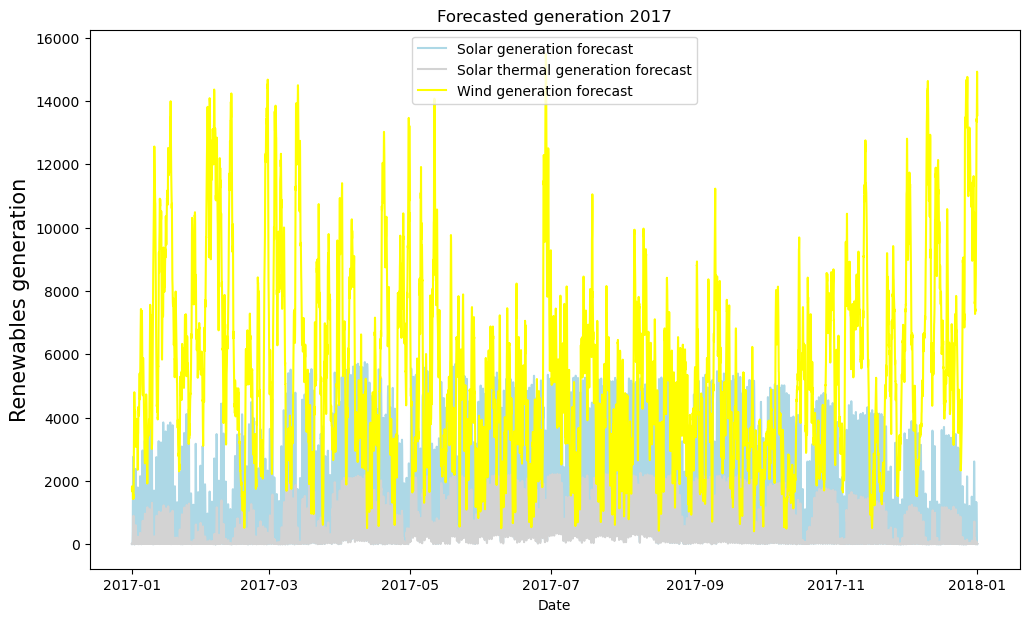

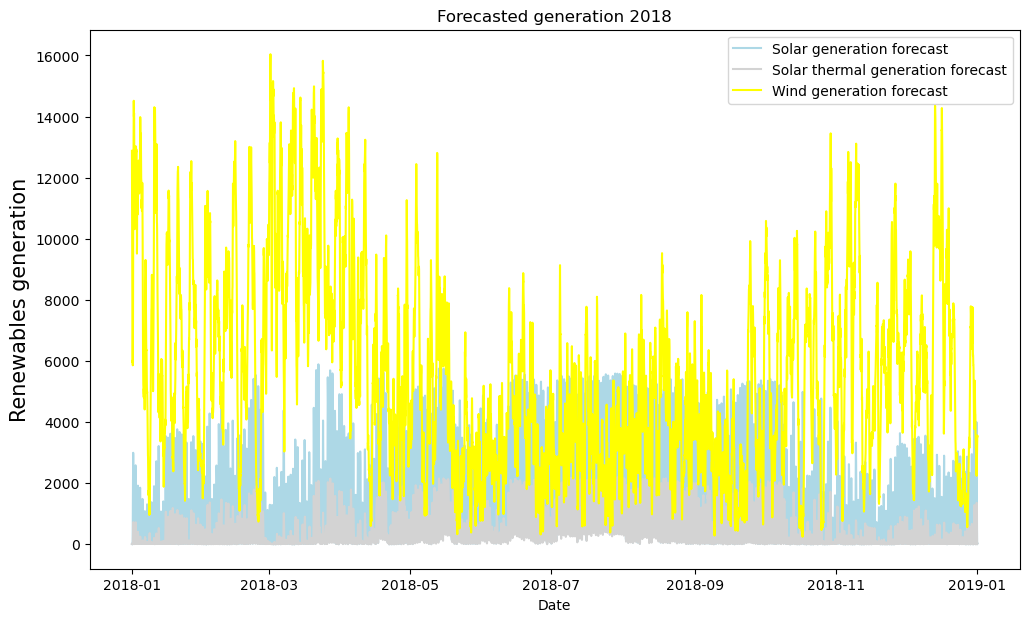

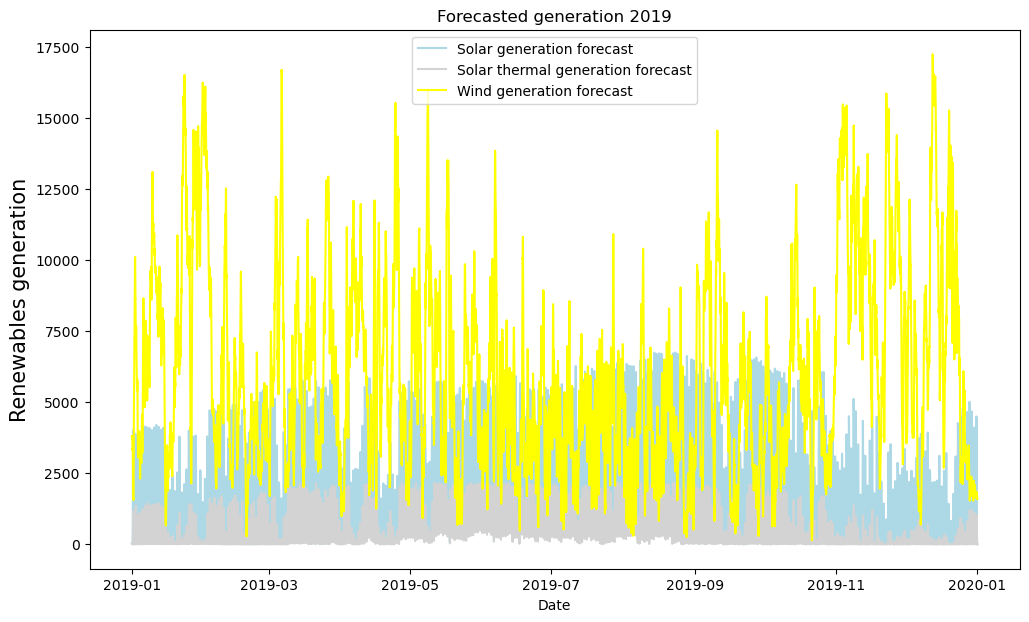

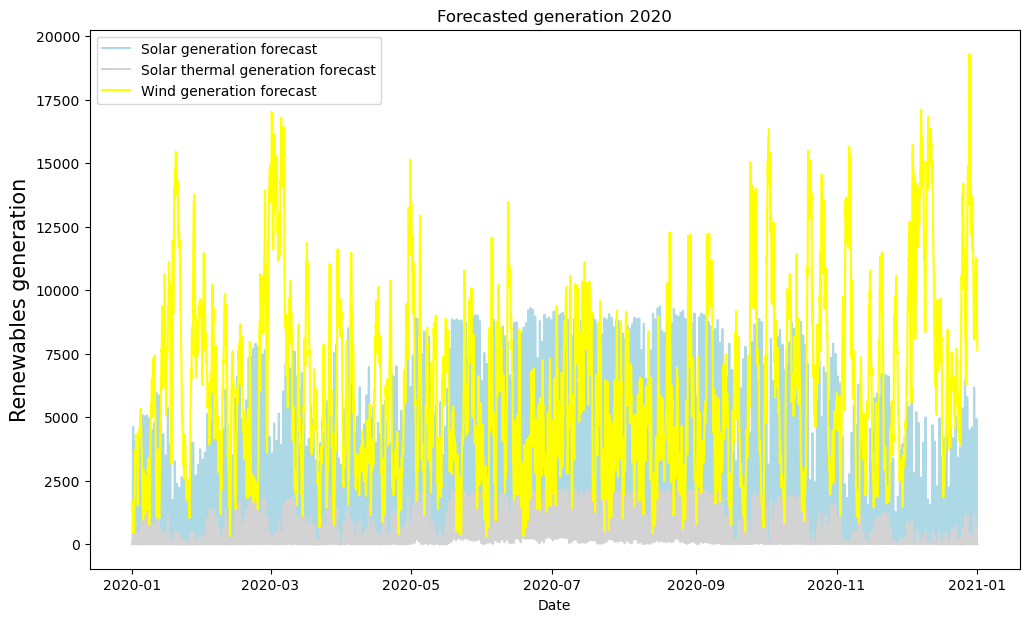

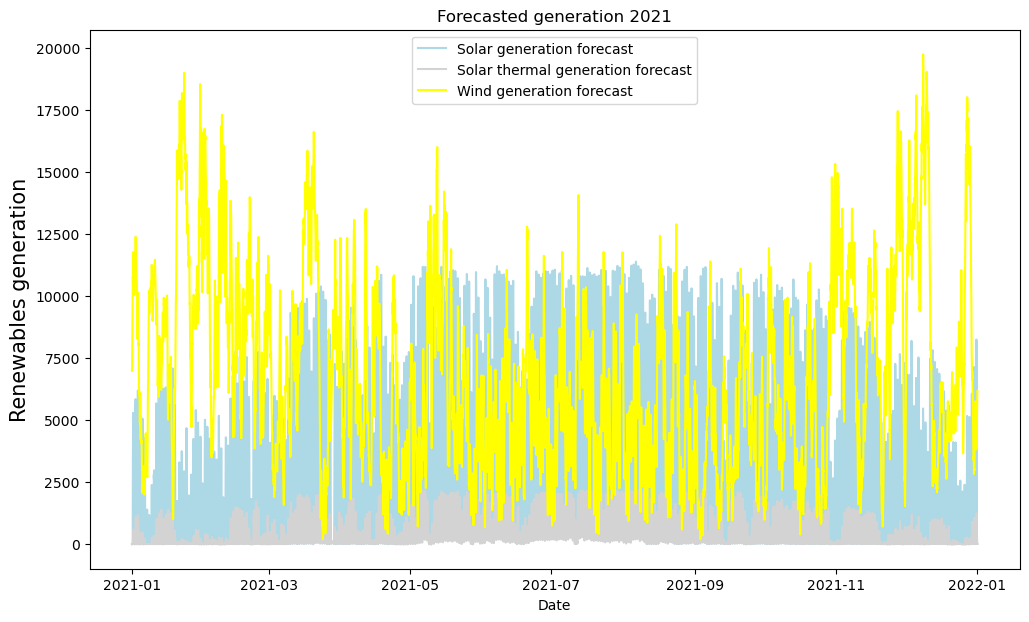

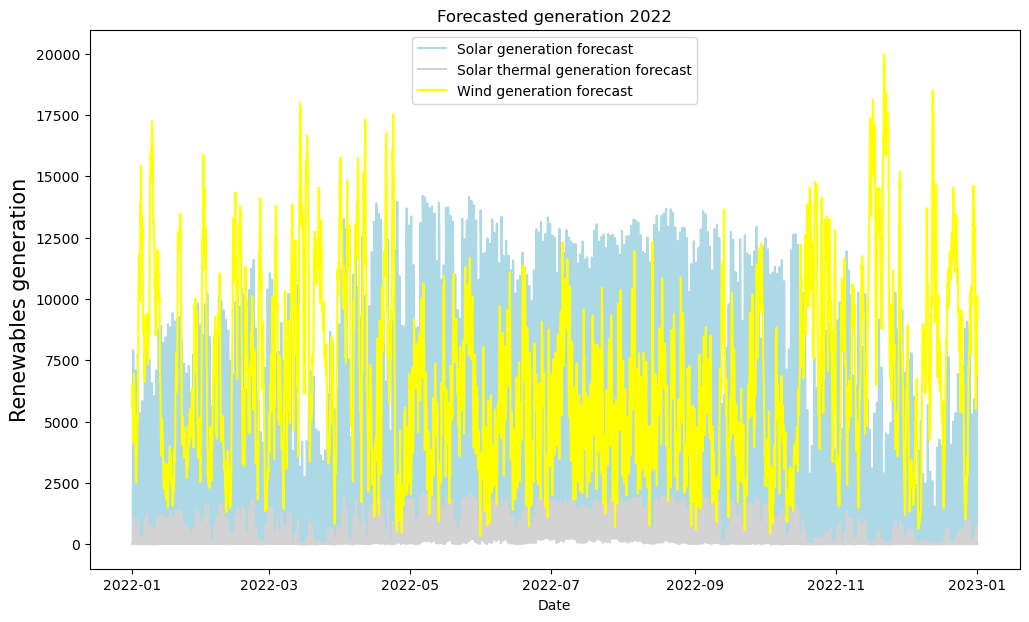

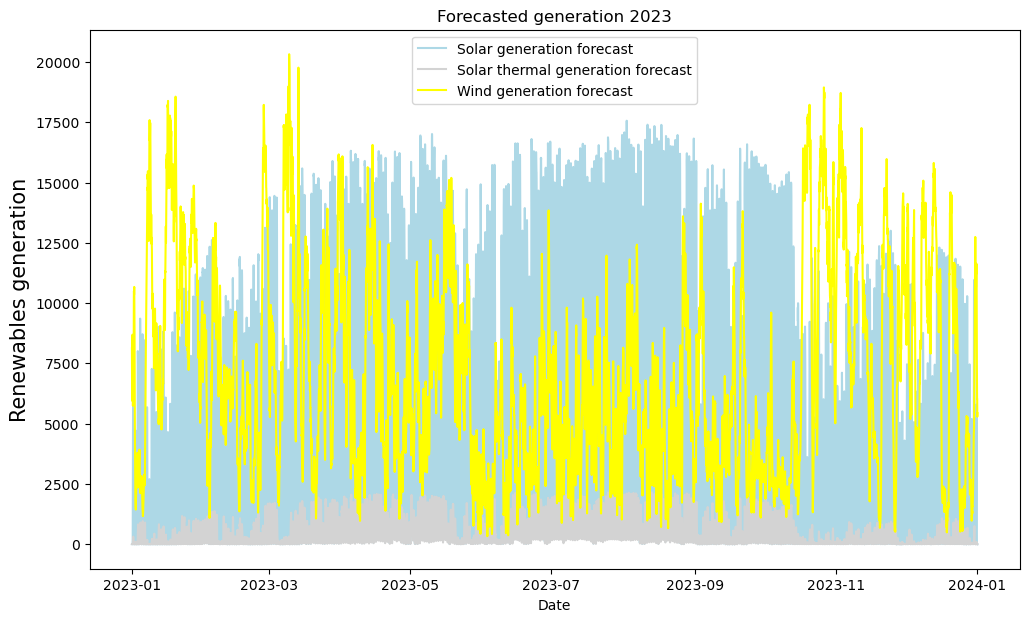

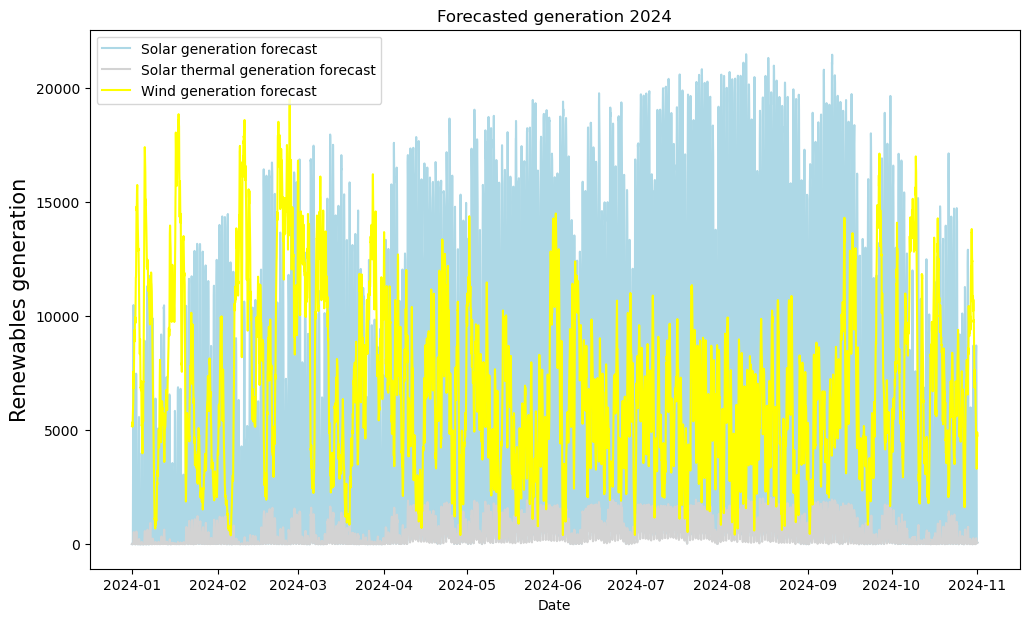

In [23]:
# Forecasted generation (Solar, solar thermal & wind)
for year, data in full_data.groupby(full_data.index.year):
    
    plt.figure(figsize=(12, 7))
    plt.plot(data['solar_gen_fore'], color = 'lightblue', label = 'Solar generation forecast')
    plt.plot(data['solar_thermal_fore'], color = 'lightgray', label = 'Solar thermal generation forecast')
    plt.plot(data['wind_gen_fore'], color = 'yellow', label = 'Wind generation forecast')
    plt.title(f'Forecasted generation {year}')
    plt.xlabel('Date')
    plt.ylabel('Renewables generation', fontsize=15)
    plt.legend()
    plt.show()

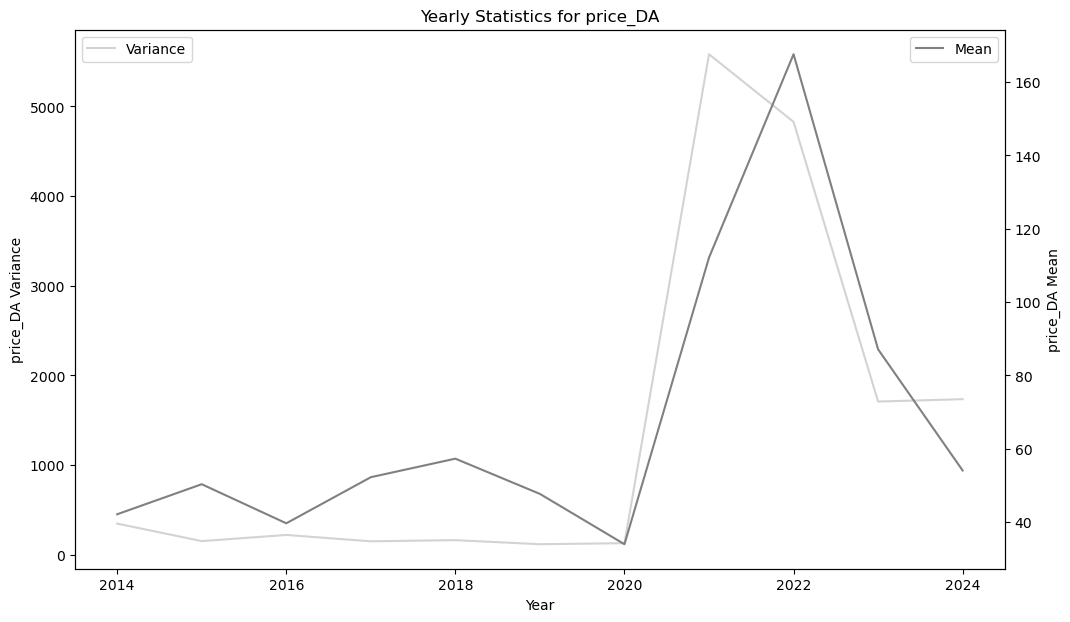

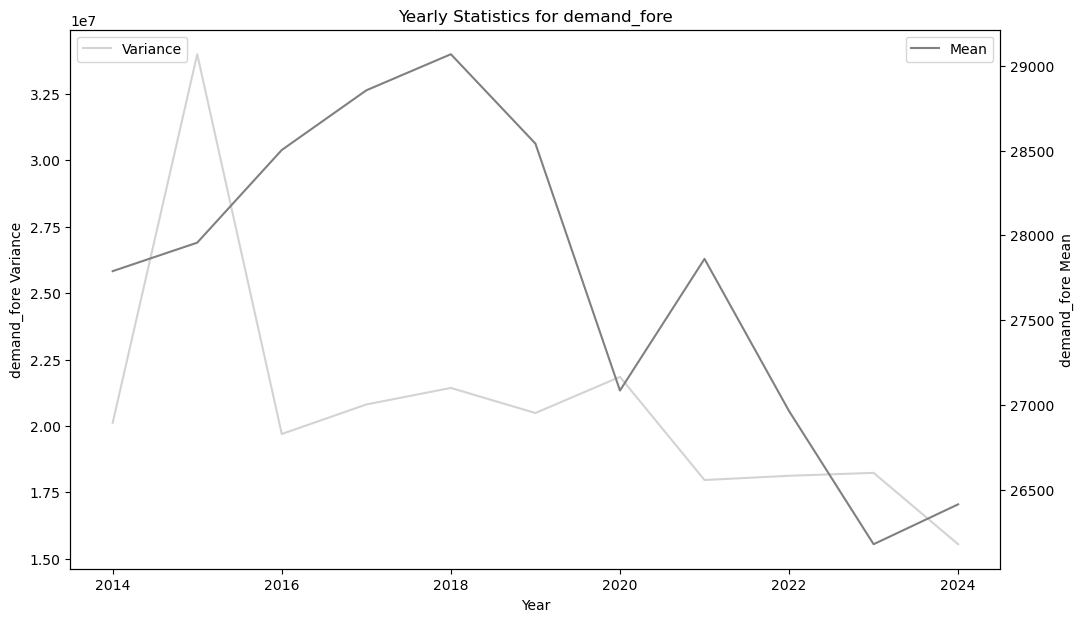

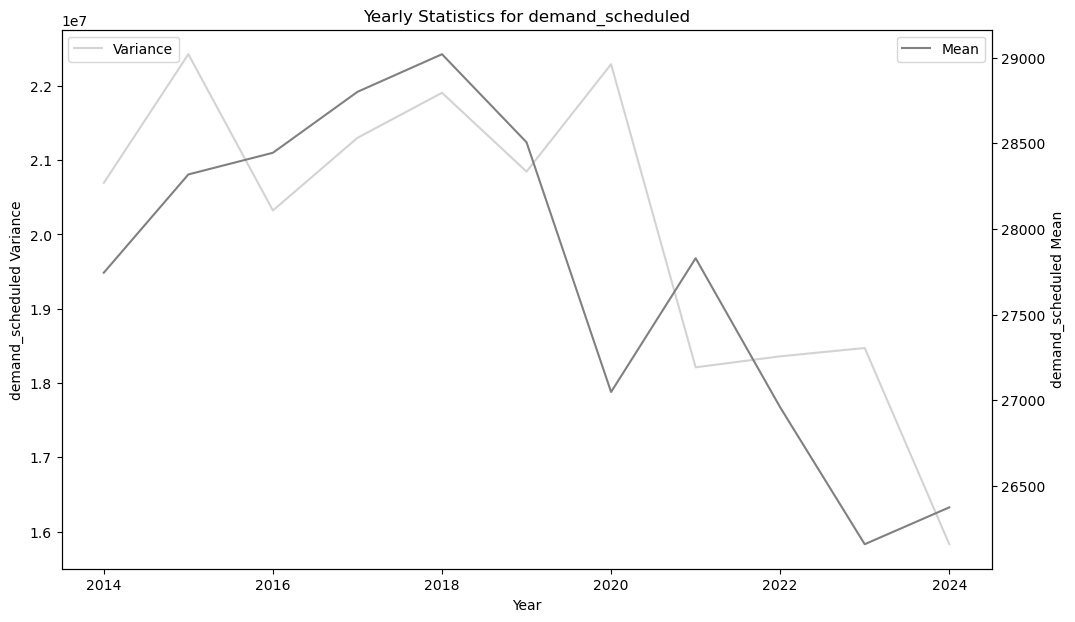

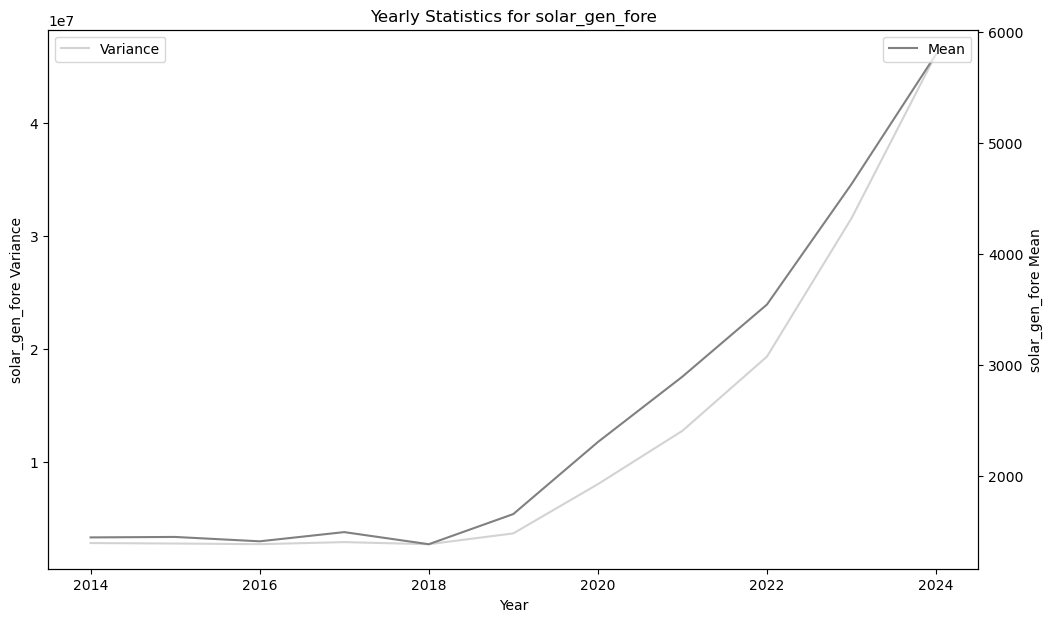

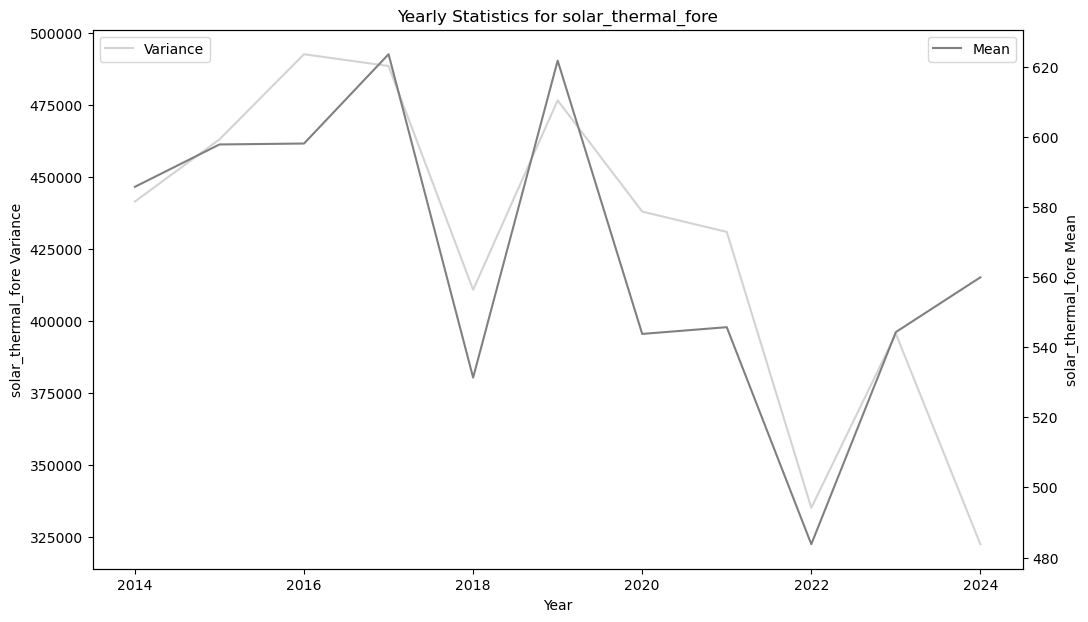

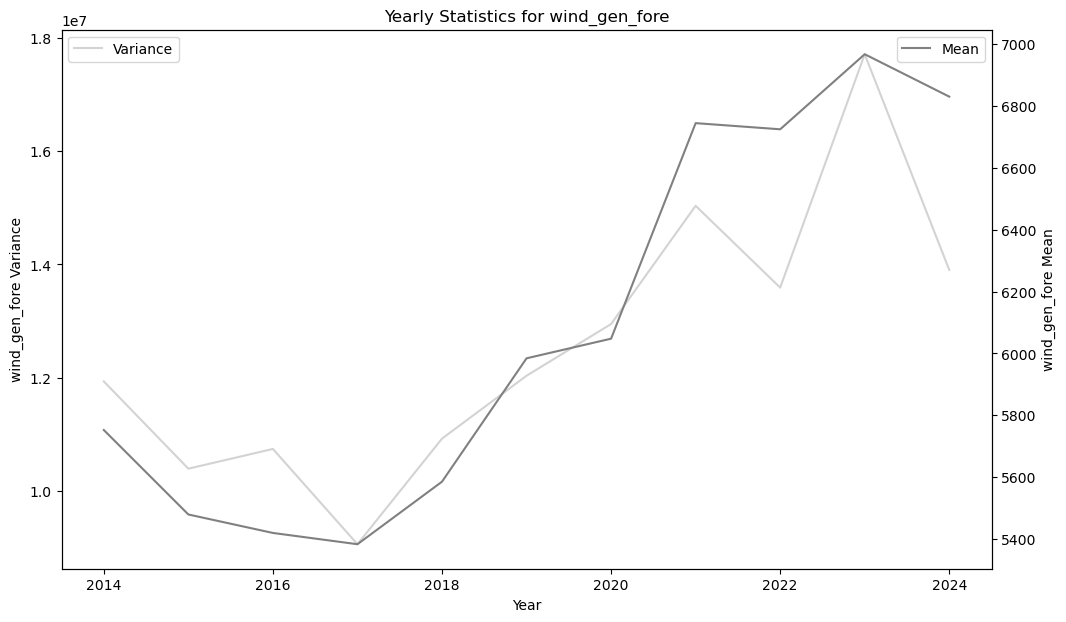

In [24]:
# Plotting the stats for each variable to see their behaviour
for variable in yearly_stats.columns.levels[0]:  # Top-level columns
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    # Plot variance on the left y-axis
    ax1.plot(yearly_stats.index, yearly_stats[variable]['var'], label='Variance', color='lightgrey')
    ax1.set_xlabel('Year')
    ax1.set_ylabel(f'{variable} Variance')
    ax1.legend(loc='upper left')
    # Second y-axis for the mean
    ax2 = ax1.twinx()
    ax2.plot(yearly_stats.index, yearly_stats[variable]['mean'], label='Mean', color='grey')
    ax2.set_ylabel(f'{variable} Mean')
    ax2.legend(loc='upper right')
    plt.title(f'Yearly Statistics for {variable}')
    plt.show()

**Note AB: Adding this section**

Density plots 
* Let's compare the distributions for each month, year and hour and compare them with the overall dataset
* In order to do so, we'll to create new input features: **month**, **year** and **hour**


In [25]:
full_data['year'] = full_data.index.year
full_data['month'] = full_data.index.month
full_data['hour'] = full_data.index.hour

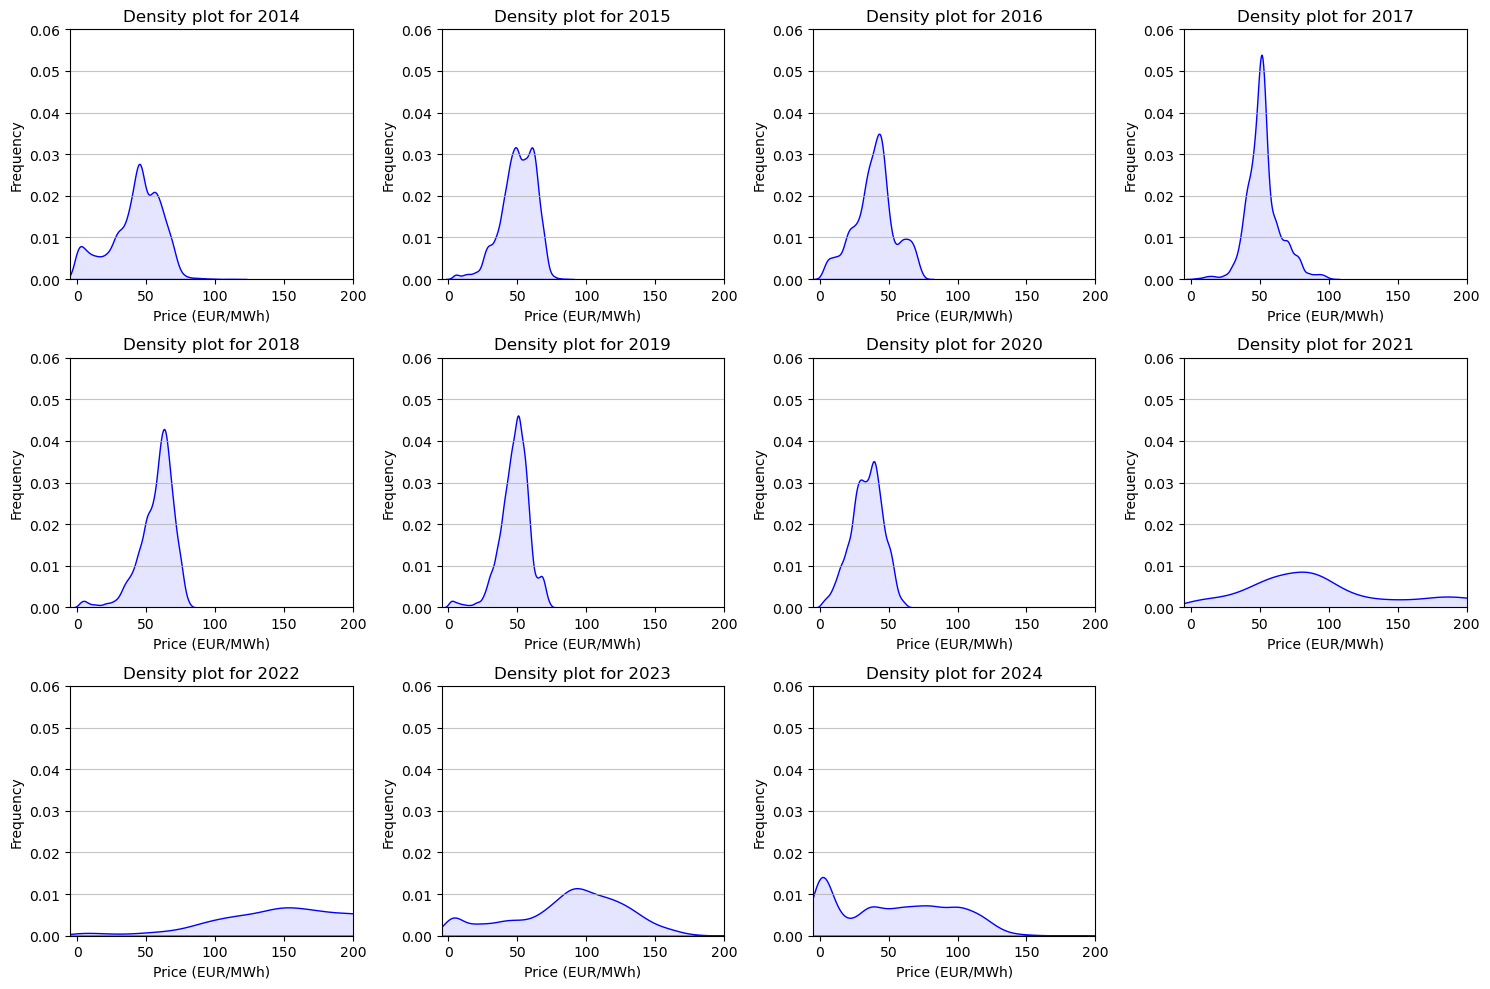

In [26]:
#For each year
import seaborn as sns
plt.figure(figsize=(15, 10))

years = range(2014, 2025)  # Including 2024

for year in years:
    plt.subplot(3, 4, year - 2013)  # Create a 3x4 grid of subplots
    sns.kdeplot(data=full_data[full_data['year'] == year]['price_DA'], color='blue', label='Weekday', fill=True, alpha=0.1)
    plt.title(f'Density plot for {year}')
    plt.xlabel('Price (EUR/MWh)')
    plt.ylabel('Frequency')
    plt.ylim([0, 0.06])
    plt.xlim([-5, 200])  # Adjust the x-axis limit for better visibility
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

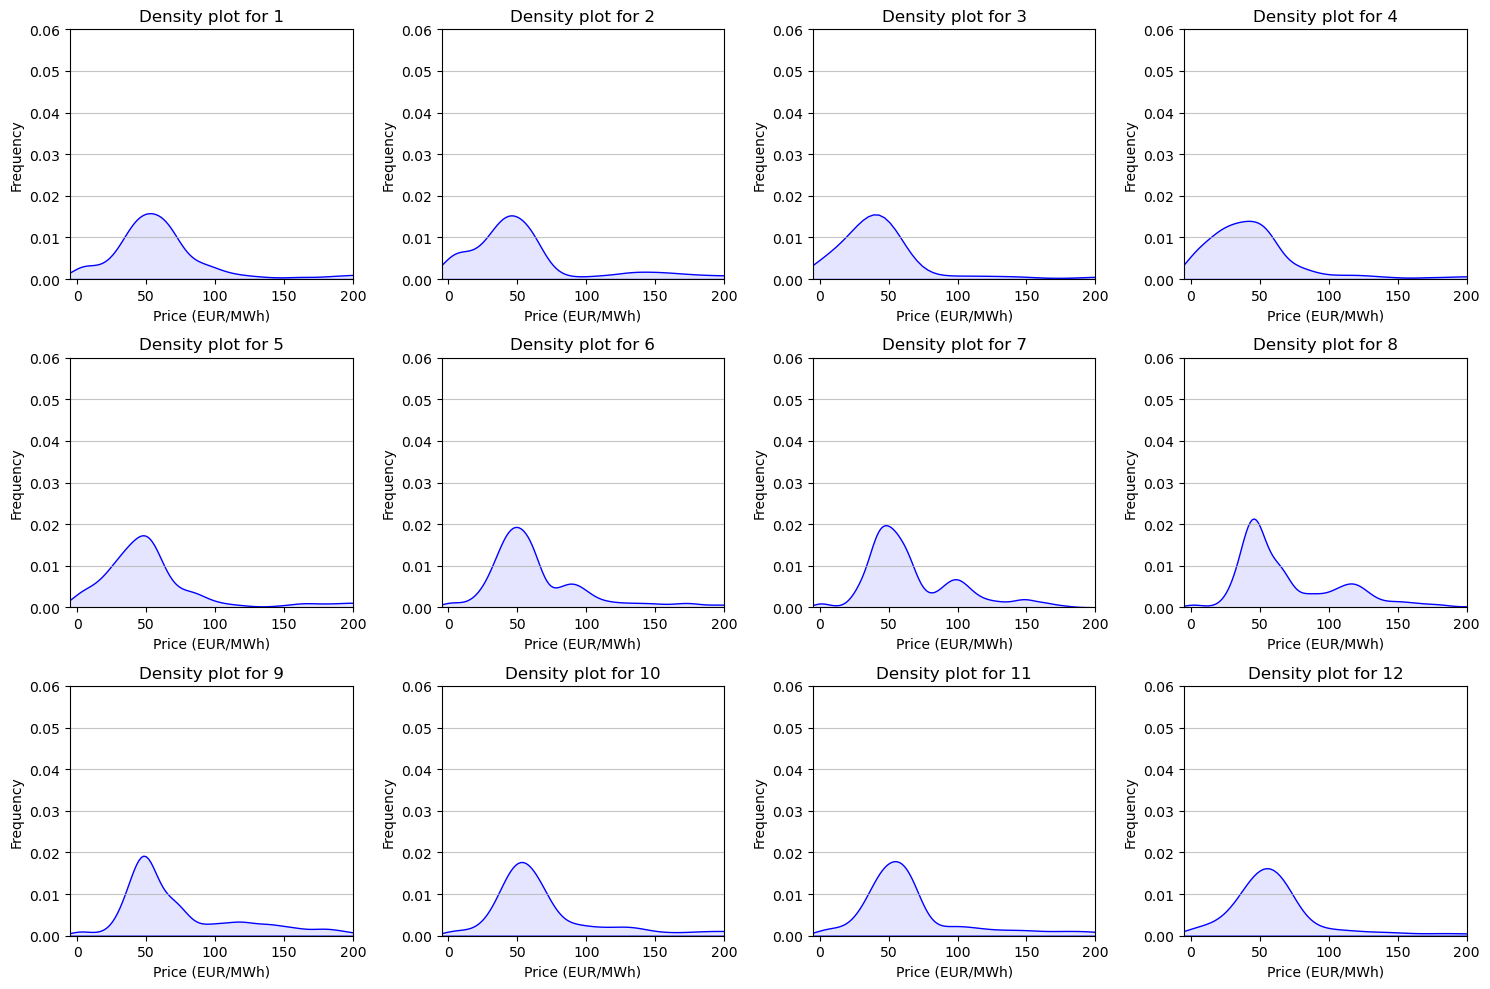

In [27]:
#For each month
import seaborn as sns
plt.figure(figsize=(15, 10))

months = range(1, 13)  

for month in months:
    plt.subplot(3, 4, month)  # Create a 3x4 grid of subplots
    sns.kdeplot(data=full_data[full_data['month'] == month]['price_DA'], color='blue', label='Weekday', fill=True, alpha=0.1)
    plt.title(f'Density plot for {month}')
    plt.xlabel('Price (EUR/MWh)')
    plt.ylabel('Frequency')
    plt.ylim([0, 0.06])
    plt.xlim([-5, 200])  # Adjust the x-axis limit for better visibility
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

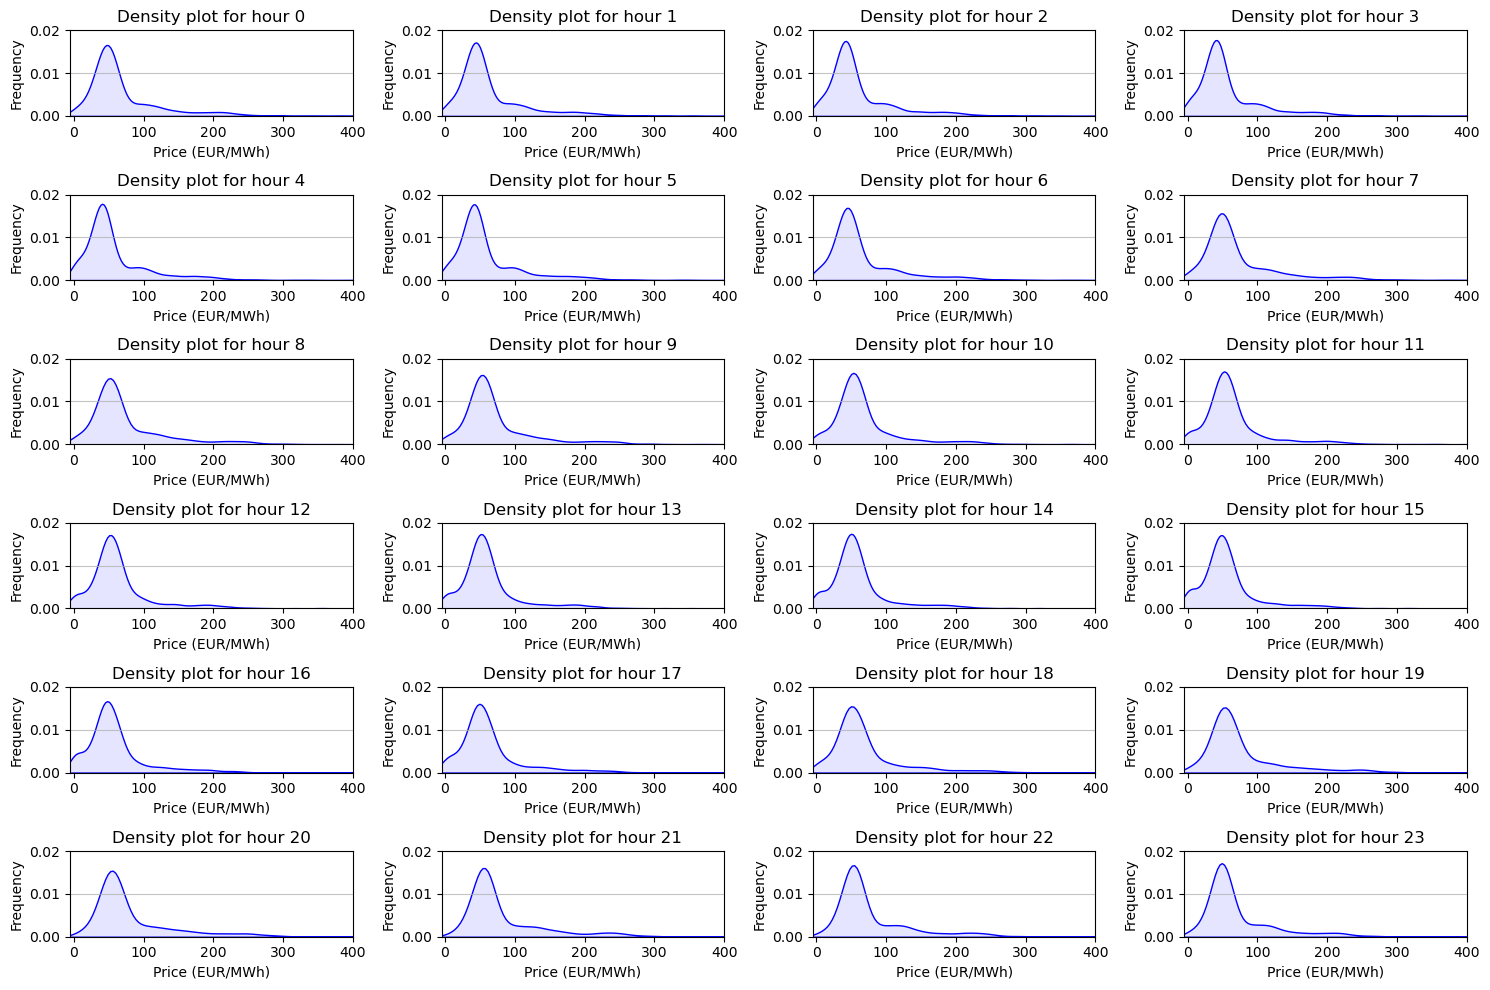

In [28]:
#For each hour
import seaborn as sns
plt.figure(figsize=(15, 10))

hours = range(0, 24)  

for hour in hours:
    plt.subplot(6, 4, hour+1)  # Create a 6x4 grid of subplots
    sns.kdeplot(data=full_data[full_data['hour'] == hour]['price_DA'], color='blue', label='Weekday', fill=True, alpha=0.1)
    plt.title(f'Density plot for hour {hour}')
    plt.xlabel('Price (EUR/MWh)')
    plt.ylabel('Frequency')
    plt.ylim([0, 0.02])
    plt.xlim([-5, 400])  # Adjust the x-axis limit for better visibility
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

**Note AB: Prices have been very different distributions depending on the year, lets use a reduced dataset of 2023 and 2024 and plot the monthly distribution, adding these plots.**

Let's look also at monthly distribution in 2023 and 2024:

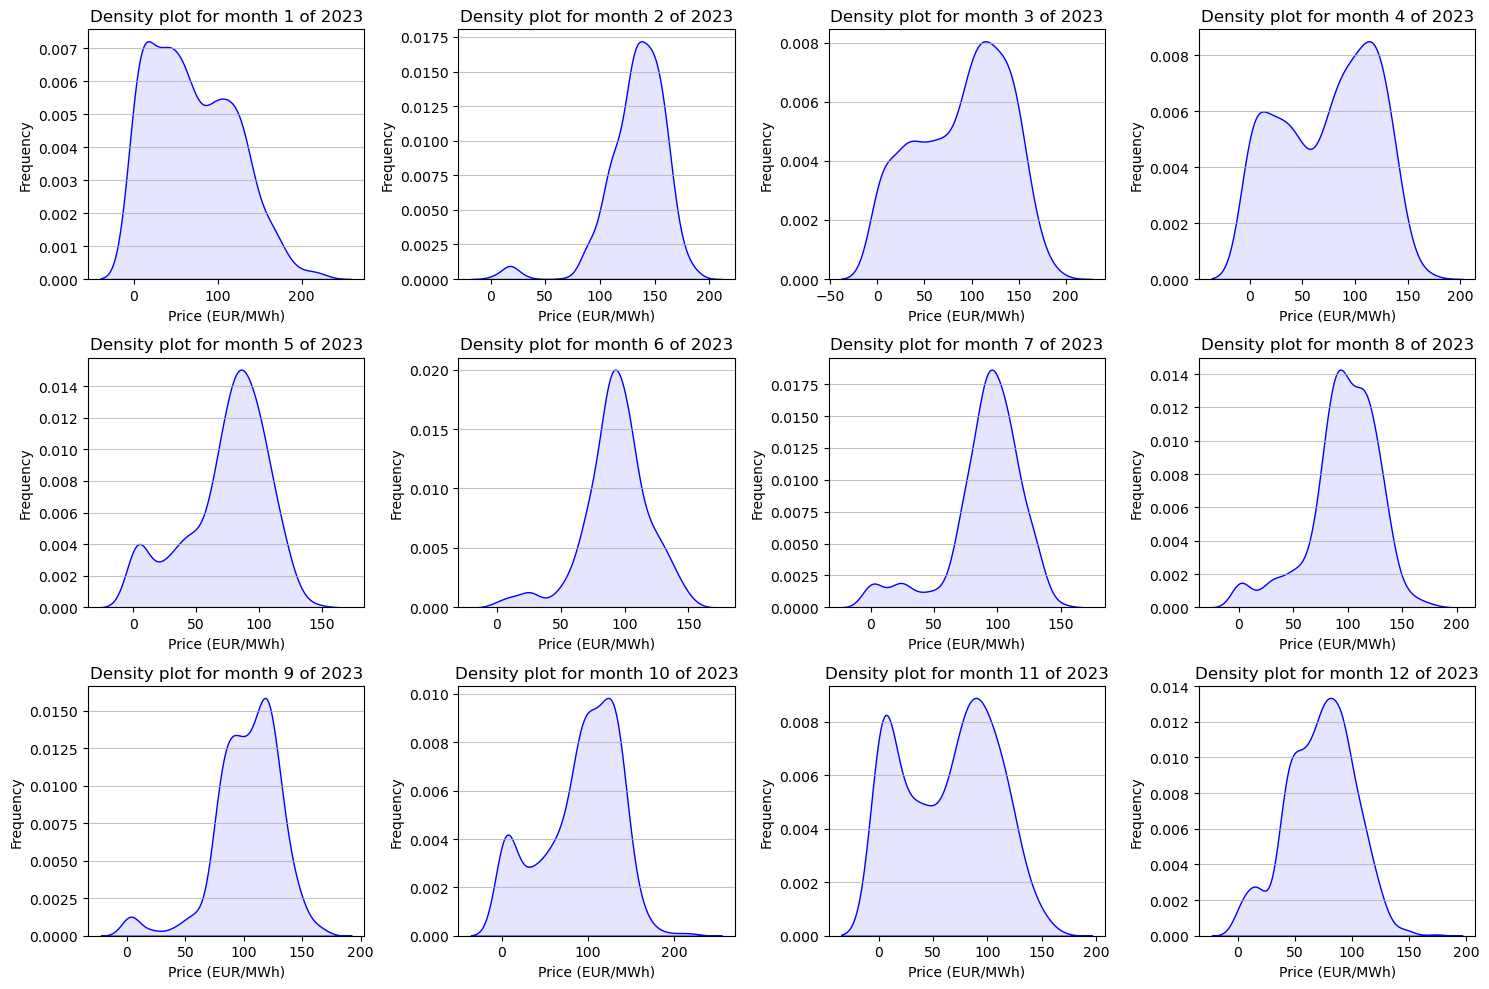

In [29]:
#For each month of 2023
import seaborn as sns
plt.figure(figsize=(15, 10))

year = 2023
months = range(1, 13)  

for month in months:
    plt.subplot(3, 4, month)  # Create a 3x4 grid of subplots
    sns.kdeplot(data=full_data[(full_data['month'] == month) & (full_data['year'] == year)]['price_DA'], color='blue', label='Weekday', fill=True, alpha=0.1)
    plt.title(f'Density plot for month {month} of 2023')
    plt.xlabel('Price (EUR/MWh)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

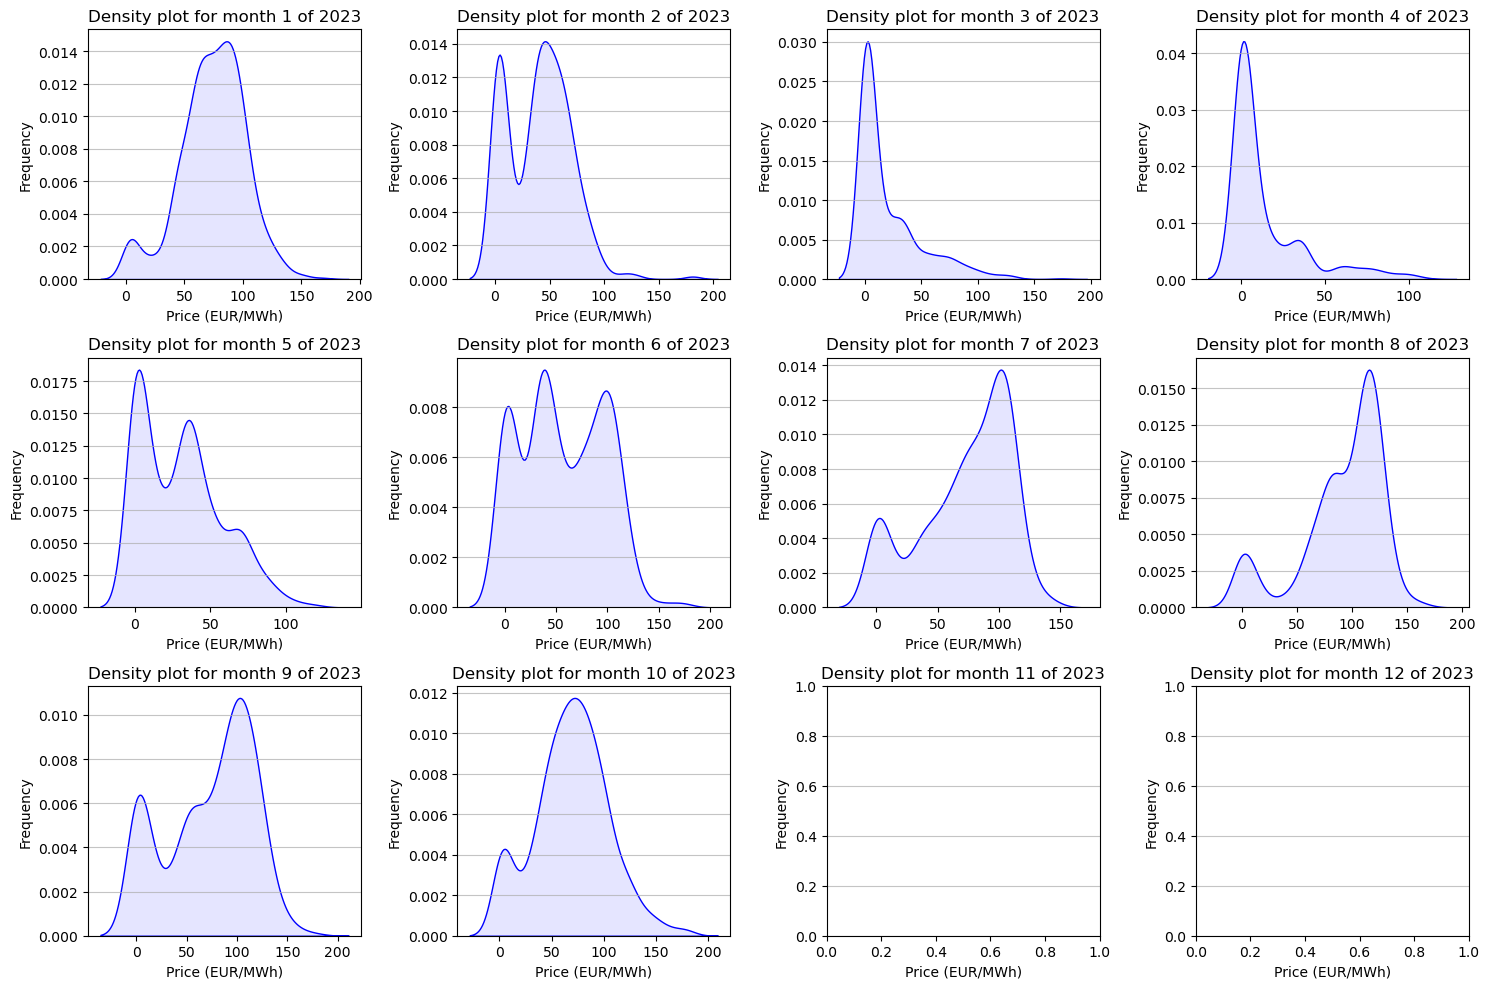

In [30]:
#For each month of 2023
import seaborn as sns
plt.figure(figsize=(15, 10))

year = 2024
months = range(1, 13)  

for month in months:
    plt.subplot(3, 4, month)  # Create a 3x4 grid of subplots
    sns.kdeplot(data=full_data[(full_data['month'] == month) & (full_data['year'] == year)]['price_DA'], color='blue', label='Weekday', fill=True, alpha=0.1)
    plt.title(f'Density plot for month {month} of 2023')
    plt.xlabel('Price (EUR/MWh)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

**Note AB: There is a monthly pattern but not so clear, based on this we could maybe use data from 2024 only.**

# END OF DATA EXPLORATION
___

# 3. DATA Cleaning

In [31]:
full_data.isna().sum()

price_DA              0
demand_fore           0
demand_scheduled      0
solar_gen_fore        0
solar_thermal_fore    0
wind_gen_fore         0
year                  0
month                 0
hour                  0
dtype: int64

In [32]:
print("Total missing data" , full_data.isna().sum().sum())

Total missing data 0


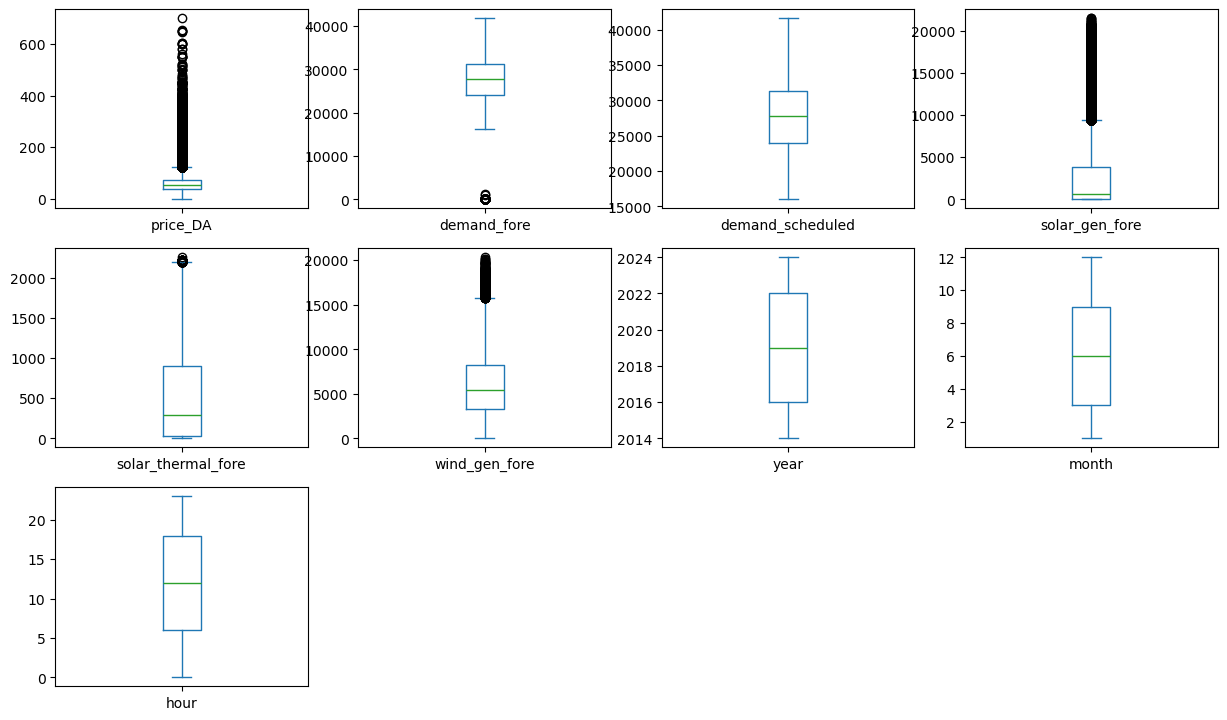

In [33]:
boxplot_attributes = full_data.plot(kind='box', subplots=True, layout=(5, 4), figsize=(15, 15),
                                 sharex=False, sharey=False, fontsize=10)

**Note AB: We're removing all outliers here, not sure if it's correct. I'm modiying que code to select only one column.**

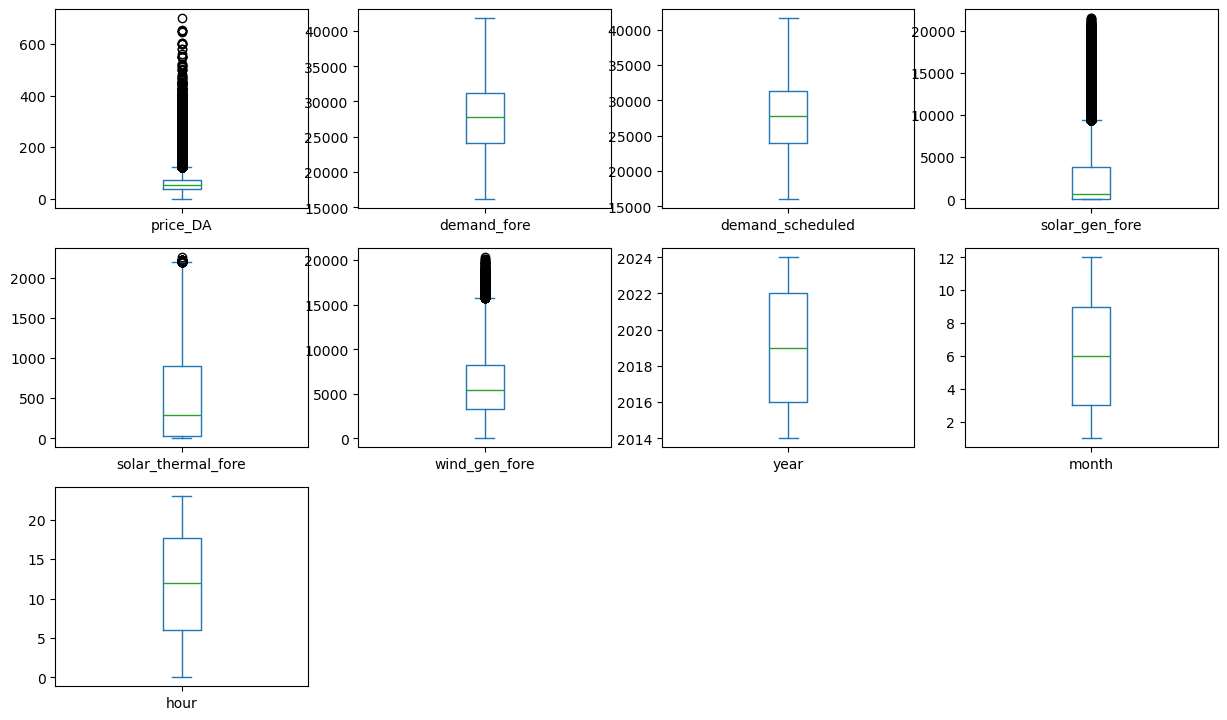

In [34]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


full_data_no_outliers = remove_outliers_iqr(full_data, 'demand_fore')


atributos_boxplot = full_data_no_outliers.plot(kind='box', subplots=True, layout=(5, 4), figsize=(15, 15),
                                 sharex=False, sharey=False, fontsize=10)

# End of DATA Cleaning

Initial plots looking for some correlations...

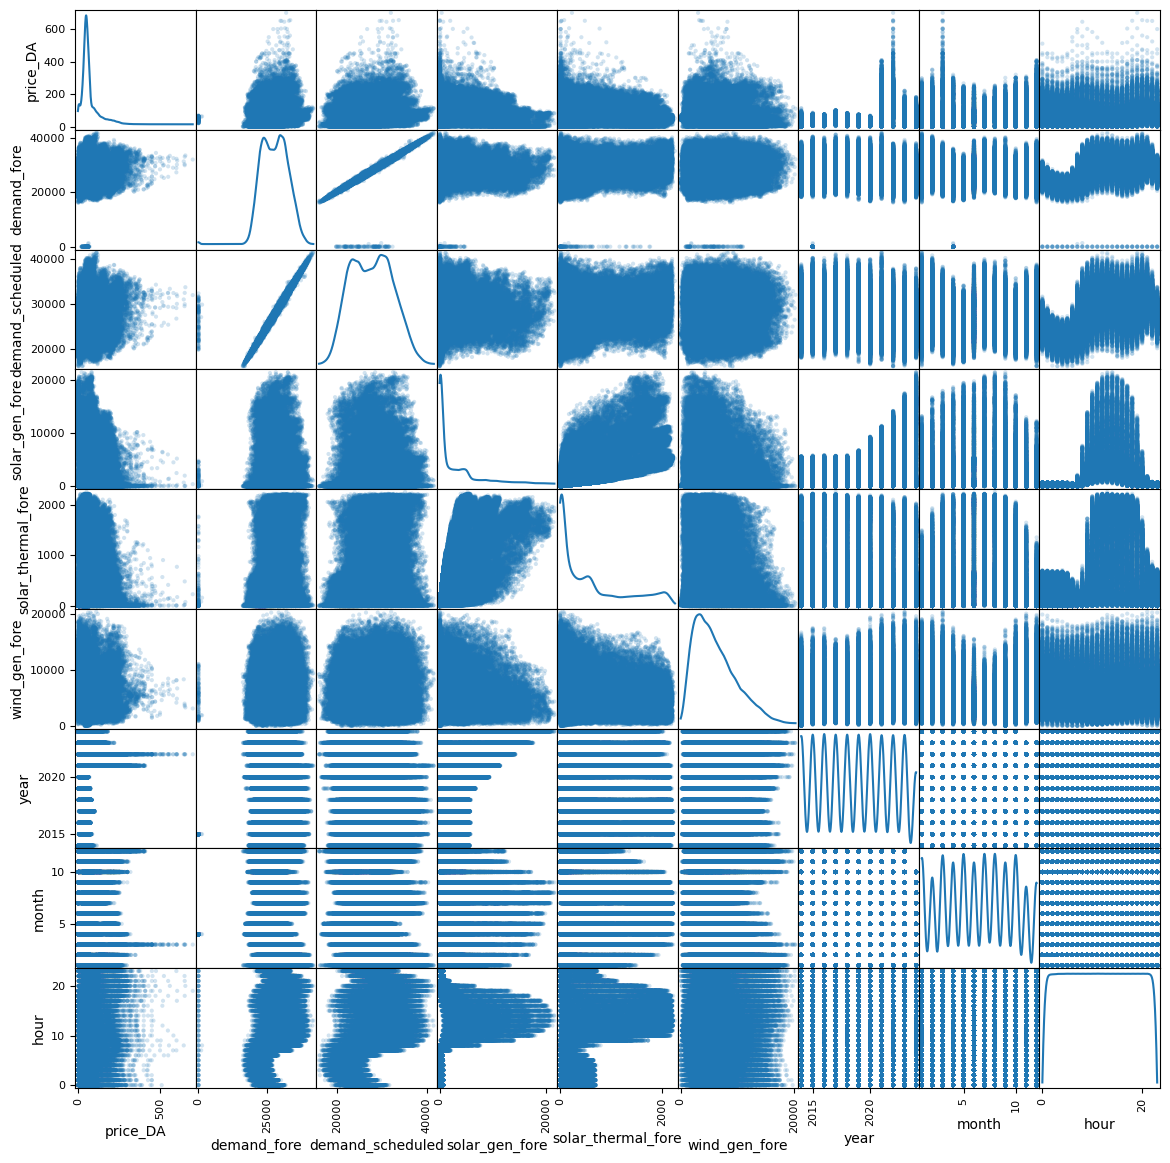

In [35]:
from pandas.plotting import scatter_matrix

scatter_matrix(full_data, alpha=0.2, figsize=(14, 14), diagonal='kde', range_padding=0.05)
plt.show()


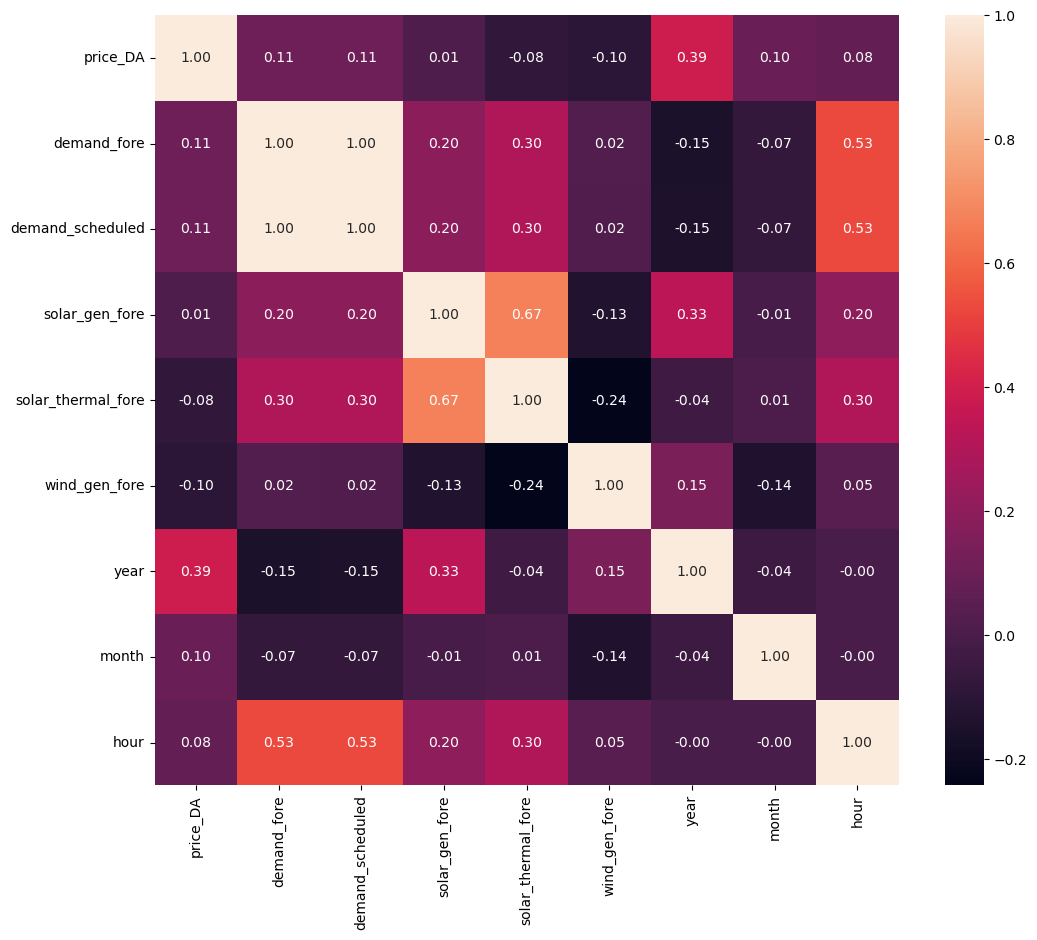

In [36]:
# Calculation of correlation coefficients
corr = full_data_no_outliers.iloc[:,0:].corr(method='pearson')  # method{‘pearson’, ‘kendall’, ‘spearman’} 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

Lets create a reduced dataset to check again, only with data from 2023 and 2024. 

In [38]:
reduced_data_no_outliers = full_data_no_outliers[(full_data_no_outliers['year']==2023)|(full_data['year']==2024)]
reduced_data_no_outliers

C:\Users\andre\AppData\Local\Temp\ipykernel_22688\2287286099.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reduced_data_no_outliers = full_data_no_outliers[(full_data_no_outliers['year']==2023)|(full_data['year']==2024)]


price_DA   demand_fore  demand_scheduled  solar_gen_fore  \
2023-01-01 00:00:00      0.00  20042.250000          20060.75           3.625   
2023-01-01 01:00:00      0.00  19383.750000          19241.00           2.325   
2023-01-01 02:00:00      0.00  18216.083333          18151.75           0.900   
2023-01-01 03:00:00      0.00  17126.666667          17043.50           0.575   
2023-01-01 04:00:00      0.00  16551.666667          16469.25           0.600   
...                       ...           ...               ...             ...   
2024-10-31 19:00:00    135.01  30143.666667          29705.50          82.550   
2024-10-31 20:00:00    148.72  29875.750000          29545.50          94.400   
2024-10-31 21:00:00    134.34  29014.000000          28285.50          97.750   
2024-10-31 22:00:00    115.20  26512.166667          25917.00          64.150   
2024-10-31 23:00:00    102.00  25230.000000          24393.00          67.500   

                     solar_thermal_fore  wind_gen_fore  year  month  hour  
2023-01-01 00:00:00               3.625        8124.00  2023      1     0  
2023-01-01 01:00:00               2.325        7173.75  2023      1     1  
2023-01-01 02:00:00               0.900        6380.75  2023      1     2  
2023-01-01 03:00:00               0.575        6469.25  2023      1     3  
2023-01-01 04:00:00               0.600        7175.50  2023      1     4  
...                                 ...            ...   ...    ...   ...  
2024-10-31 19:00:00              82.550        3972.75  2024     10    19  
2024-10-31 20:00:00              94.400        4615.25  2024     10    20  
2024-10-31 21:00:00              97.750        4913.00  2024     10    21  
2024-10-31 22:00:00              64.150        4820.25  2024     10    22  
2024-10-31 23:00:00              67.500        4765.00  2024     10    23  

[16078 rows x 9 columns]

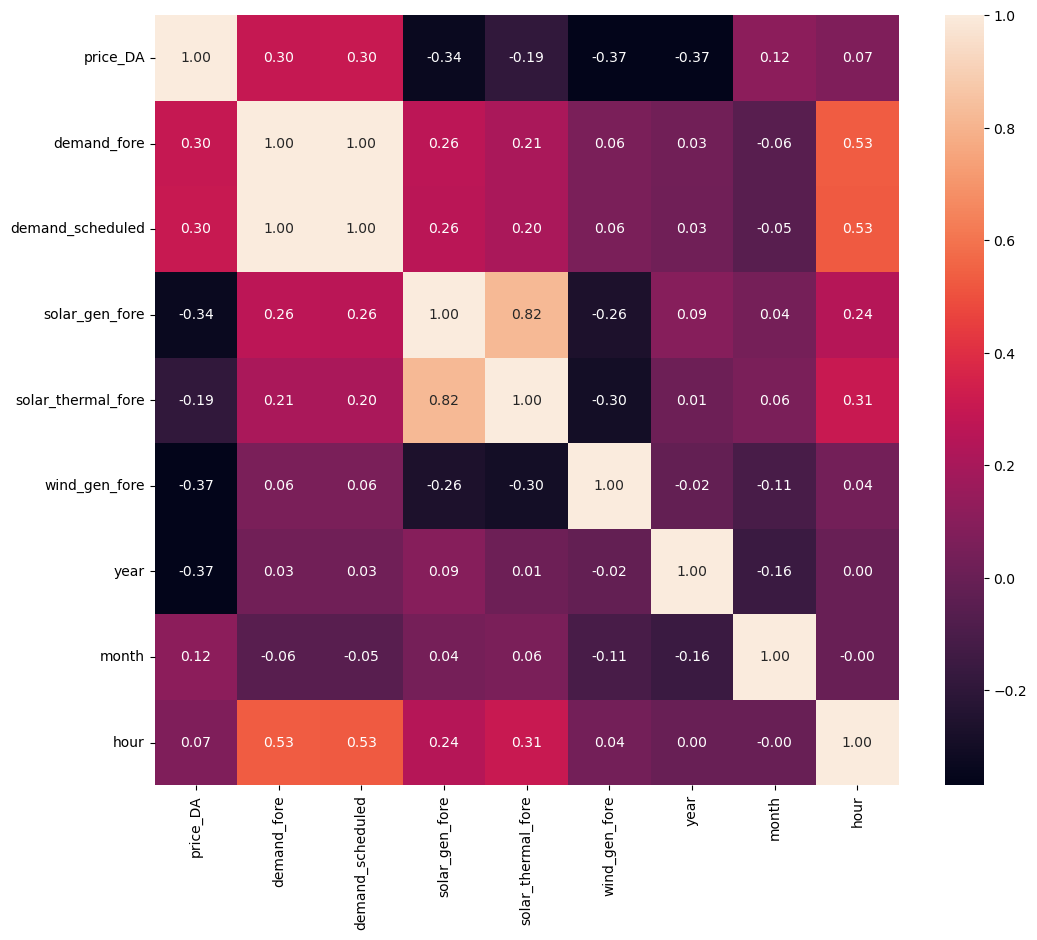

In [39]:
# Calculation of correlation coefficients
corr = reduced_data_no_outliers.iloc[:,0:].corr(method='pearson')  # method{‘pearson’, ‘kendall’, ‘spearman’} 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

The correlation coefficients improve when considering a reduced dataset. 

# Feature Creation, normalization and standardization

Time Based, Lagged and rolling Features
Time-based features help capture patterns in the data related to daily, weekly, or seasonal cycle.


Lagged features help the model see recent values, allowing it to learn short-term dependencies. For instance, if energy prices were high in the last hour, they might still be high. They are applied selectively to columns where recent values are likely to influence future values, particularly ic areas like prices, demand, and variable renewab generation. \

.
Rolling (averaged) features are applied to specific columns where understanding recent trends or cumulative effects over short to medium timefra es (e.g., 3, 6, or 24 hours) is particularly useful for predicting future values. coloumns with price, demand and renewable generat \
on.

**Note AB: I don't think we should lag the forecasts of demand and generation because we'll have this data, I'll lag only prices**

All added features (coloumns) are standardized and normalized.

In [42]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Function to add time-based features
def create_time_based_features(data):
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    data['day_of_week'] = data.index.dayofweek # The day of the week (0=Monday, 6=Sunday).
    data['week_of_year'] = data.index.isocalendar().week # The week number in the year (1-52), which can help identify seasonal patterns.
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) # A flag indicating if the day is a weekend (1 for Saturday/Sunday, 0 otherwise).
    return data

# Function to create lagged features
def create_lagged_features(data, columns, lags=[24, 48]):
    for column in columns:
        for lag in lags:
            data[f"{column}_lag_{lag}"] = data[column].shift(lag)
    return data

# Function to create rolling/averaged features
def create_rolling_features(data, columns, windows=[24, 48], agg_func="mean"):
    for column in columns:
        for window in windows:
            if agg_func == "mean":
                data[f"{column}_roll_mean_{window}"] = data[column].rolling(window=window, min_periods=1).mean()
            elif agg_func == "sum":
                data[f"{column}_roll_sum_{window}"] = data[column].rolling(window=window, min_periods=1).sum()
    return data


# time-based features
reduced_data_with_features = create_time_based_features(reduced_data_no_outliers)

# lagged features
lagged_columns = ['price_DA']
#lagged_columns = ['price_DA', 'demand_prevista', 'demand_prog', 'prevision_produccion_eolica', 'generacion_prevista_solar']
reduced_data_with_features = create_lagged_features(reduced_data_no_outliers, lagged_columns)

# Add rolling features
price_column = ['price_DA']
demand_columns = ['demand_prevista', 'demand_prog']
#generation_columns = ['pbf_total', 'pbf_eolica', 'pbf_solar_fot']
generation_columns = ['prevision_produccion_eolica', 'generacion_prevista_solar']
reduced_data_with_features = create_rolling_features(reduced_data_no_outliers, price_column, windows=[24,48], agg_func="mean")
#full_data_with_features = create_rolling_features(full_data_with_features, demand_columns, windows=[3, 6, 24], agg_func="mean")
#full_data_with_features = create_rolling_features(full_data_with_features, generation_columns, windows=[3, 6, 24], agg_func="mean")

# Collect names of all added columns (time-based, lagged, and rolling features)
time_based_columns = ['hour', 'day_of_week', 'month', 'week_of_year', 'is_weekend']
lagged_feature_columns = [f"{col}_lag_{lag}" for col in lagged_columns for lag in [24, 48]]
rolling_feature_columns = [f"{col}_roll_mean_{win}" for col in price_column + demand_columns + generation_columns for win in [3, 6, 24]]
added_columns = time_based_columns + lagged_feature_columns + rolling_feature_columns

reduced_data_with_features 

C:\Users\andre\AppData\Local\Temp\ipykernel_22688\2337333440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_of_week'] = data.index.dayofweek # The day of the week (0=Monday, 6=Sunday).
C:\Users\andre\AppData\Local\Temp\ipykernel_22688\2337333440.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['week_of_year'] = data.index.isocalendar().week # The week number in the year (1-52), which can help identify seasonal patterns.
C:\Users\andre\AppData\Local\Temp\ipykernel_22688\2337333440.py:1

price_DA   demand_fore  demand_scheduled  solar_gen_fore  \
2023-01-01 00:00:00      0.00  20042.250000          20060.75           3.625   
2023-01-01 01:00:00      0.00  19383.750000          19241.00           2.325   
2023-01-01 02:00:00      0.00  18216.083333          18151.75           0.900   
2023-01-01 03:00:00      0.00  17126.666667          17043.50           0.575   
2023-01-01 04:00:00      0.00  16551.666667          16469.25           0.600   
...                       ...           ...               ...             ...   
2024-10-31 19:00:00    135.01  30143.666667          29705.50          82.550   
2024-10-31 20:00:00    148.72  29875.750000          29545.50          94.400   
2024-10-31 21:00:00    134.34  29014.000000          28285.50          97.750   
2024-10-31 22:00:00    115.20  26512.166667          25917.00          64.150   
2024-10-31 23:00:00    102.00  25230.000000          24393.00          67.500   

                     solar_thermal_fore  wind_gen_fore  year  month  hour  \
2023-01-01 00:00:00               3.625        8124.00  2023      1     0   
2023-01-01 01:00:00               2.325        7173.75  2023      1     1   
2023-01-01 02:00:00               0.900        6380.75  2023      1     2   
2023-01-01 03:00:00               0.575        6469.25  2023      1     3   
2023-01-01 04:00:00               0.600        7175.50  2023      1     4   
...                                 ...            ...   ...    ...   ...   
2024-10-31 19:00:00              82.550        3972.75  2024     10    19   
2024-10-31 20:00:00              94.400        4615.25  2024     10    20   
2024-10-31 21:00:00              97.750        4913.00  2024     10    21   
2024-10-31 22:00:00              64.150        4820.25  2024     10    22   
2024-10-31 23:00:00              67.500        4765.00  2024     10    23   

                     day_of_week  week_of_year  is_weekend  price_DA_lag_24  \
2023-01-01 00:00:00            6            52           1              NaN   
2023-01-01 01:00:00            6            52           1              NaN   
2023-01-01 02:00:00            6            52           1              NaN   
2023-01-01 03:00:00            6            52           1              NaN   
2023-01-01 04:00:00            6            52           1              NaN   
...                          ...           ...         ...              ...   
2024-10-31 19:00:00            3            44           0           143.36   
2024-10-31 20:00:00            3            44           0           143.36   
2024-10-31 21:00:00            3            44           0           132.33   
2024-10-31 22:00:00            3            44           0            99.80   
2024-10-31 23:00:00            3            44           0            91.71   

                     price_DA_lag_48  price_DA_roll_mean_24  \
2023-01-01 00:00:00              NaN               0.000000   
2023-01-01 01:00:00              NaN               0.000000   
2023-01-01 02:00:00              NaN               0.000000   
2023-01-01 03:00:00              NaN               0.000000   
2023-01-01 04:00:00              NaN               0.000000   
...                              ...                    ...   
2024-10-31 19:00:00            93.34              99.792083   
2024-10-31 20:00:00            98.61             100.015417   
2024-10-31 21:00:00            90.00             100.099167   
2024-10-31 22:00:00            83.22             100.740833   
2024-10-31 23:00:00            68.70             101.169583   

                     price_DA_roll_mean_48  
2023-01-01 00:00:00               0.000000  
2023-01-01 01:00:00               0.000000  
2023-01-01 02:00:00               0.000000  
2023-01-01 03:00:00               0.000000  
2023-01-01 04:00:00               0.000000  
...                                    ...  
2024-10-31 19:00:00              89.002708  
2024-10-31 20:00:00              90.046667  
2024-10-31 2

## AB: Correlation matrix again
Significant correlation with lagged variables and rolling average.

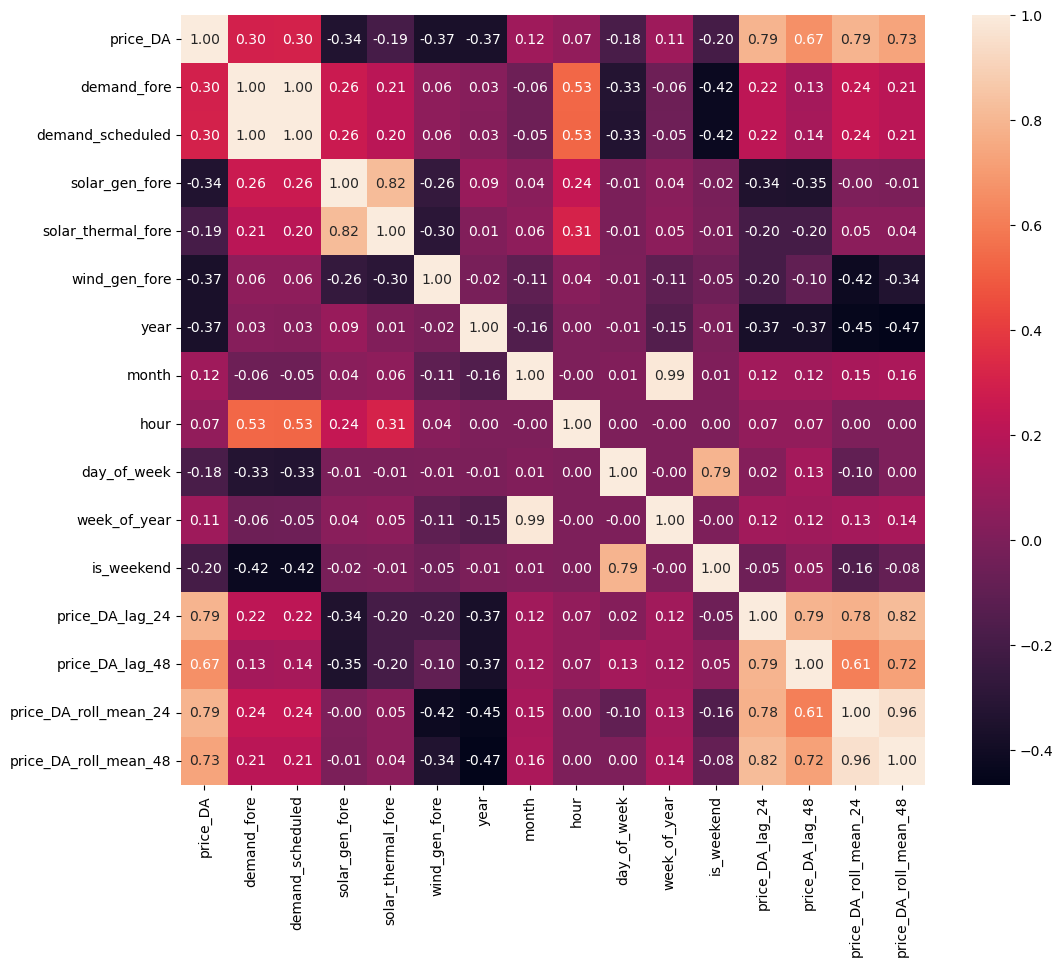

In [43]:
# Calculation of correlation coefficients
corr = reduced_data_with_features.iloc[:,0:].corr(method='pearson')  # method{‘pearson’, ‘kendall’, ‘spearman’} 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

**Note AB: I think we should do this when splitting the training set, otherwise we'll use the same scaler for all the data**

In [ ]:
# Selecting only added columns for normalization and scaling
added_features = reduced_data_with_features[added_columns]

# Standardize the features
scaler_standard = StandardScaler()
standardized_features = pd.DataFrame(scaler_standard.fit_transform(added_features), columns=added_columns, index=added_features.index)

# Normalize the features to 0-1 range
scaler_minmax = MinMaxScaler()
normalized_features = pd.DataFrame(scaler_minmax.fit_transform(added_features), columns=added_columns, index=added_features.index)

# Display standardized and normalized features separately
print("Standardized Features (Mean=0, SD=1):")
print(standardized_features.head())

print("\nNormalized Features (0-1 range):")
print(normalized_features.head())

### Volitality Features
adding price volatility features, then standardize them. \
These features help the model identify trends or sudden shifts in pricing. Short term standard deviation and price differences reveal market conditions that may affect future prices. \
For volatility features, only doing standardization captures the extent of variability around the mean. \
Normalization would scale volatility features to a 0-1 range, losing valuable information about how much they deviate. \

In [44]:
from sklearn.preprocessing import StandardScaler
# Function to create price volatility features
def create_price_volatility_features(data, price_column='price_DA', std_windows=[3]):
    # Price difference (Diff) feature
    data[f"{price_column}_diff"] = data[price_column].diff() # Calculates the difference between the current and previous price. This helps capture sudden changes in price, which may indicate volatility.
    
    # Rolling standard deviation of price over specified windows
    for window in std_windows: # Computes the rolling standard deviation of prices over a 3-hour window, helping to capture short-term price volatility.
        data[f"{price_column}_roll_std_{window}"] = data[price_column].rolling(window=window, min_periods=1).std()
    
    return data

# Apply the function to add price volatility features
reduced_data_with_volatility_features = create_price_volatility_features(reduced_data_with_features, price_column='price_DA', std_windows=[3])

# Collect the newly added volatility feature columns
volatility_feature_columns = ['price_DA_diff', 'price_DA_roll_std_3']

# Display only the added price volatility feature columns
print(reduced_data_with_volatility_features[volatility_feature_columns].head())


# Selecting volatility features for standardization
volatility_features = reduced_data_with_volatility_features[volatility_feature_columns]

# Applying standardization Note AB: removing this for now
#scaler = StandardScaler()
#standardized_volatility_features = pd.DataFrame(scaler.fit_transform(volatility_features), columns=volatility_feature_columns, index=volatility_features.index)

# Display standardized volatility features
#print(standardized_volatility_features.head())


                     price_DA_diff  price_DA_roll_std_3
2023-01-01 00:00:00            NaN                  NaN
2023-01-01 01:00:00            0.0                  0.0
2023-01-01 02:00:00            0.0                  0.0
2023-01-01 03:00:00            0.0                  0.0
2023-01-01 04:00:00            0.0                  0.0


C:\Users\andre\AppData\Local\Temp\ipykernel_22688\2982309618.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{price_column}_diff"] = data[price_column].diff() # Calculates the difference between the current and previous price. This helps capture sudden changes in price, which may indicate volatility.
C:\Users\andre\AppData\Local\Temp\ipykernel_22688\2982309618.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{price_column}_roll_std_{window}"] = data[price_column].rolling(window=window, 

## AB: Correlation matrix again

not so good correlation with these features

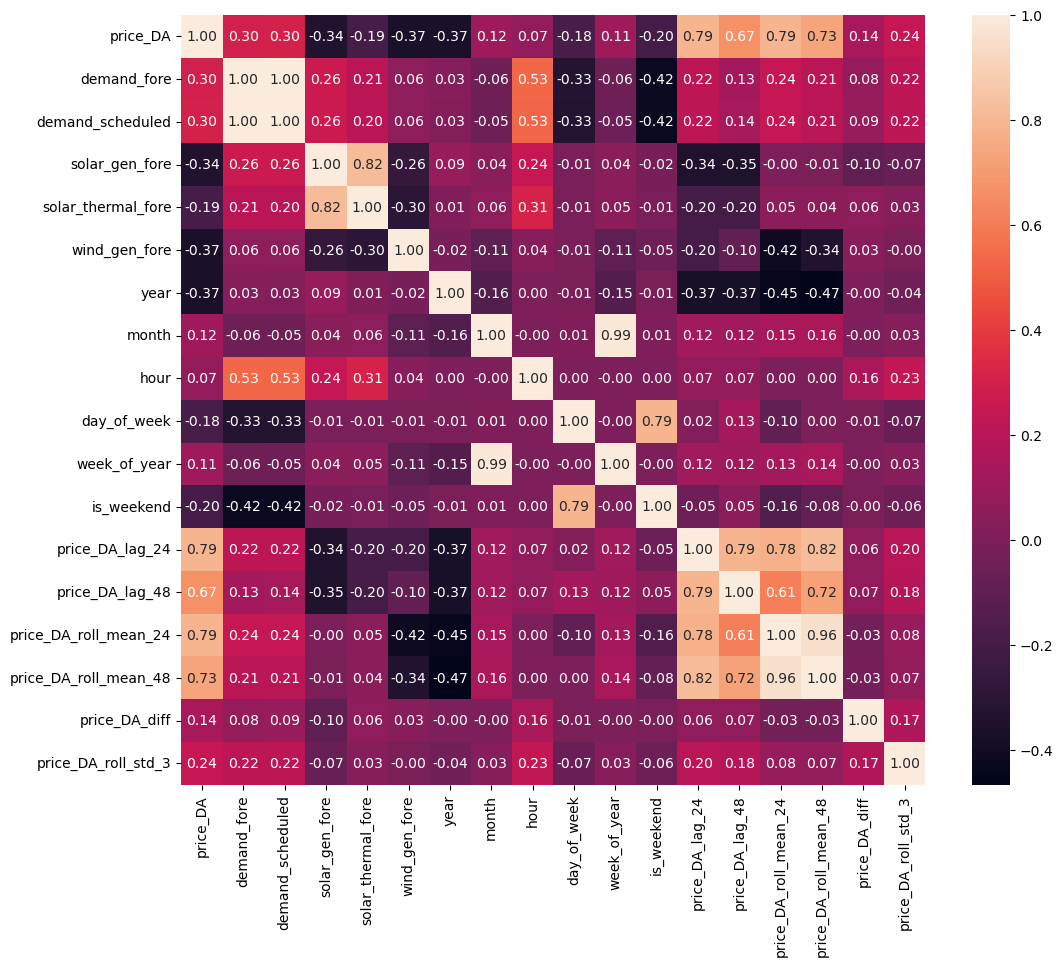

In [45]:
# Calculation of correlation coefficients
corr = reduced_data_with_volatility_features.iloc[:,0:].corr(method='pearson')  # method{‘pearson’, ‘kendall’, ‘spearman’} 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()